ㄱㄴㄷㄹ

# patch_size를 1, 3, 5, 7, 9, 11로 바꾸어 가면서 테스트 해 보자

In [1]:
from utils.utils import train_model, evaluate_model_with_cm, TiffDataset
from models.image_classifier import ResNetLike_48
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
test_filter = lambda box_number: (box_number % 9 == 0 or box_number % 9 == 5)

### 데이터 준비함수, 학습 평가 함수 정의

In [4]:
# 이미지 전처리 (Naive)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
])

# 데이터셋 생성 함수
def create_datasets(patch_size):
    dataset_kwargs = {
        "large_tif_dir": '/home/elicer/forest_carbon_ai/data/source_data/naive',
        "file_list": ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"],
        "label_file": '/home/elicer/forest_carbon_ai/data/label_data/label_mapping_sampled.csv',
        "patch_size": patch_size,
        "transform": transform
    }
    return (
        TiffDataset(**dataset_kwargs, box_filter_fn=lambda box_number: not test_filter(box_number)),  # train
        TiffDataset(**dataset_kwargs, box_filter_fn=test_filter)  # val
    )

# 데이터로더 생성 함수
def create_dataloaders(train_dataset, val_dataset, batch_size=32, num_workers=0):
    return (
        DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
        DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    )

# 학습 및 평가 함수
def train_and_evaluate(patch_size, train_loader, val_loader, num_epochs=30):
    print(f"Training with patch size: {patch_size}")

    model = ResNetLike_48(num_classes=6).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_model_state, train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100
    )
    
    torch.save(best_model_state, f"patch_size_test_{patch_size}_{num_epochs}.pth")
    model.load_state_dict(best_model_state)
    
    print("\ntrain data")
    evaluate_model_with_cm(model, train_loader, num_classes=6)
    print("\nvalidation data")
    evaluate_model_with_cm(model, val_loader, num_classes=6)


### 패치사이즈를 바꾸어가며 테스트

1
Training with patch size: 1


Epoch 1/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 211.75it/s]



Epoch [1/50], Train Loss: 0.5707, Train Accuracy: 78.53%, Val Loss: 0.5943, Val Accuracy: 77.66%



Epoch 2/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 212.71it/s]



Epoch [2/50], Train Loss: 0.4463, Train Accuracy: 83.31%, Val Loss: 0.6770, Val Accuracy: 73.28%



Epoch 3/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 212.61it/s]



Epoch [3/50], Train Loss: 0.4075, Train Accuracy: 84.71%, Val Loss: 0.7878, Val Accuracy: 73.79%



Epoch 4/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 213.21it/s]



Epoch [4/50], Train Loss: 0.3822, Train Accuracy: 85.63%, Val Loss: 0.5577, Val Accuracy: 81.27%



Epoch 5/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 212.76it/s]



Epoch [5/50], Train Loss: 0.3640, Train Accuracy: 86.45%, Val Loss: 0.5814, Val Accuracy: 80.15%



Epoch 6/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 213.15it/s]



Epoch [6/50], Train Loss: 0.3472, Train Accuracy: 87.14%, Val Loss: 0.5516, Val Accuracy: 81.63%



Epoch 7/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 210.52it/s]



Epoch [7/50], Train Loss: 0.3360, Train Accuracy: 87.57%, Val Loss: 0.6025, Val Accuracy: 80.14%



Epoch 8/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 213.03it/s]



Epoch [8/50], Train Loss: 0.3249, Train Accuracy: 87.95%, Val Loss: 0.5979, Val Accuracy: 81.11%



Epoch 9/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 210.86it/s]



Epoch [9/50], Train Loss: 0.3171, Train Accuracy: 88.26%, Val Loss: 0.5685, Val Accuracy: 82.02%



Epoch 10/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 211.14it/s]



Epoch [10/50], Train Loss: 0.3056, Train Accuracy: 88.62%, Val Loss: 0.7925, Val Accuracy: 72.56%



Epoch 11/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 214.01it/s]



Epoch [11/50], Train Loss: 0.2985, Train Accuracy: 88.95%, Val Loss: 0.5305, Val Accuracy: 81.06%



Epoch 12/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 213.06it/s]



Epoch [12/50], Train Loss: 0.2925, Train Accuracy: 89.23%, Val Loss: 0.4844, Val Accuracy: 84.23%



Epoch 13/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 213.51it/s]



Epoch [13/50], Train Loss: 0.2864, Train Accuracy: 89.44%, Val Loss: 0.5646, Val Accuracy: 82.69%



Epoch 14/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 210.79it/s]



Epoch [14/50], Train Loss: 0.2815, Train Accuracy: 89.57%, Val Loss: 0.5647, Val Accuracy: 81.65%



Epoch 15/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 210.70it/s]



Epoch [15/50], Train Loss: 0.2792, Train Accuracy: 89.64%, Val Loss: 0.5558, Val Accuracy: 82.21%



Epoch 16/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 210.66it/s]



Epoch [16/50], Train Loss: 0.2730, Train Accuracy: 89.89%, Val Loss: 0.5894, Val Accuracy: 79.36%



Epoch 17/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 211.89it/s]



Epoch [17/50], Train Loss: 0.2662, Train Accuracy: 90.10%, Val Loss: 0.5431, Val Accuracy: 82.51%



Epoch 18/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 210.76it/s]



Epoch [18/50], Train Loss: 0.2638, Train Accuracy: 90.19%, Val Loss: 0.6332, Val Accuracy: 78.33%



Epoch 19/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 210.93it/s]



Epoch [19/50], Train Loss: 0.2588, Train Accuracy: 90.42%, Val Loss: 0.5767, Val Accuracy: 82.81%



Epoch 20/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 210.84it/s]



Epoch [20/50], Train Loss: 0.2574, Train Accuracy: 90.45%, Val Loss: 0.6735, Val Accuracy: 79.08%



Epoch 21/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 211.12it/s]



Epoch [21/50], Train Loss: 0.2530, Train Accuracy: 90.60%, Val Loss: 0.5189, Val Accuracy: 83.42%



Epoch 22/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 212.23it/s]



Epoch [22/50], Train Loss: 0.2496, Train Accuracy: 90.76%, Val Loss: 0.5394, Val Accuracy: 82.93%



Epoch 23/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 212.70it/s]



Epoch [23/50], Train Loss: 0.2472, Train Accuracy: 90.87%, Val Loss: 0.5218, Val Accuracy: 83.22%



Epoch 24/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 212.87it/s]



Epoch [24/50], Train Loss: 0.2426, Train Accuracy: 90.99%, Val Loss: 0.5258, Val Accuracy: 84.79%



Epoch 25/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 214.31it/s]



Epoch [25/50], Train Loss: 0.2405, Train Accuracy: 91.07%, Val Loss: 0.4945, Val Accuracy: 84.59%



Epoch 26/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 211.66it/s]



Epoch [26/50], Train Loss: 0.2388, Train Accuracy: 91.10%, Val Loss: 0.5806, Val Accuracy: 81.85%



Epoch 27/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 213.31it/s]



Epoch [27/50], Train Loss: 0.2347, Train Accuracy: 91.43%, Val Loss: 0.6266, Val Accuracy: 78.91%



Epoch 28/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 214.55it/s]



Epoch [28/50], Train Loss: 0.2339, Train Accuracy: 91.39%, Val Loss: 0.6033, Val Accuracy: 81.05%



Epoch 29/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 216.67it/s]



Epoch [29/50], Train Loss: 0.2311, Train Accuracy: 91.39%, Val Loss: 0.5151, Val Accuracy: 84.09%



Epoch 30/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 215.57it/s]



Epoch [30/50], Train Loss: 0.2264, Train Accuracy: 91.65%, Val Loss: 0.5915, Val Accuracy: 82.96%



Epoch 31/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 215.65it/s]



Epoch [31/50], Train Loss: 0.2266, Train Accuracy: 91.66%, Val Loss: 0.5417, Val Accuracy: 82.74%



Epoch 32/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 216.65it/s]



Epoch [32/50], Train Loss: 0.2231, Train Accuracy: 91.67%, Val Loss: 0.5759, Val Accuracy: 82.21%



Epoch 33/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 215.76it/s]



Epoch [33/50], Train Loss: 0.2214, Train Accuracy: 91.77%, Val Loss: 0.5726, Val Accuracy: 83.09%



Epoch 34/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 212.75it/s]



Epoch [34/50], Train Loss: 0.2180, Train Accuracy: 91.85%, Val Loss: 0.5874, Val Accuracy: 80.42%



Epoch 35/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 216.58it/s]



Epoch [35/50], Train Loss: 0.2187, Train Accuracy: 91.92%, Val Loss: 0.6113, Val Accuracy: 82.48%



Epoch 36/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 215.45it/s]



Epoch [36/50], Train Loss: 0.2145, Train Accuracy: 92.05%, Val Loss: 0.5672, Val Accuracy: 83.29%



Epoch 37/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 214.89it/s]



Epoch [37/50], Train Loss: 0.2136, Train Accuracy: 92.08%, Val Loss: 0.5766, Val Accuracy: 83.51%



Epoch 38/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 215.60it/s]



Epoch [38/50], Train Loss: 0.2113, Train Accuracy: 92.15%, Val Loss: 0.6115, Val Accuracy: 81.43%



Epoch 39/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 215.55it/s]



Epoch [39/50], Train Loss: 0.2094, Train Accuracy: 92.23%, Val Loss: 0.5830, Val Accuracy: 82.36%



Epoch 40/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 216.12it/s]



Epoch [40/50], Train Loss: 0.2072, Train Accuracy: 92.36%, Val Loss: 0.6136, Val Accuracy: 81.77%



Epoch 41/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 213.44it/s]



Epoch [41/50], Train Loss: 0.2034, Train Accuracy: 92.44%, Val Loss: 0.6234, Val Accuracy: 81.73%



Epoch 42/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 213.04it/s]



Epoch [42/50], Train Loss: 0.2049, Train Accuracy: 92.39%, Val Loss: 0.6509, Val Accuracy: 80.33%



Epoch 43/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 213.23it/s]



Epoch [43/50], Train Loss: 0.2026, Train Accuracy: 92.45%, Val Loss: 0.6545, Val Accuracy: 82.32%



Epoch 44/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 215.29it/s]



Epoch [44/50], Train Loss: 0.2007, Train Accuracy: 92.47%, Val Loss: 0.5969, Val Accuracy: 82.22%



Epoch 45/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 216.52it/s]



Epoch [45/50], Train Loss: 0.1981, Train Accuracy: 92.63%, Val Loss: 0.6035, Val Accuracy: 82.10%



Epoch 46/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 215.59it/s]



Epoch [46/50], Train Loss: 0.1978, Train Accuracy: 92.67%, Val Loss: 0.6744, Val Accuracy: 80.93%



Epoch 47/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 215.90it/s]



Epoch [47/50], Train Loss: 0.1964, Train Accuracy: 92.75%, Val Loss: 0.6107, Val Accuracy: 83.00%



Epoch 48/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 209.88it/s]



Epoch [48/50], Train Loss: 0.1944, Train Accuracy: 92.80%, Val Loss: 0.5902, Val Accuracy: 82.33%



Epoch 49/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 215.48it/s]



Epoch [49/50], Train Loss: 0.1935, Train Accuracy: 92.78%, Val Loss: 0.5733, Val Accuracy: 81.30%



Epoch 50/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 216.87it/s]



Epoch [50/50], Train Loss: 0.1907, Train Accuracy: 92.90%, Val Loss: 0.6583, Val Accuracy: 80.22%

train data


Evaluation Progress: 100%|██████████| 3683/3683 [00:16<00:00, 216.75it/s]


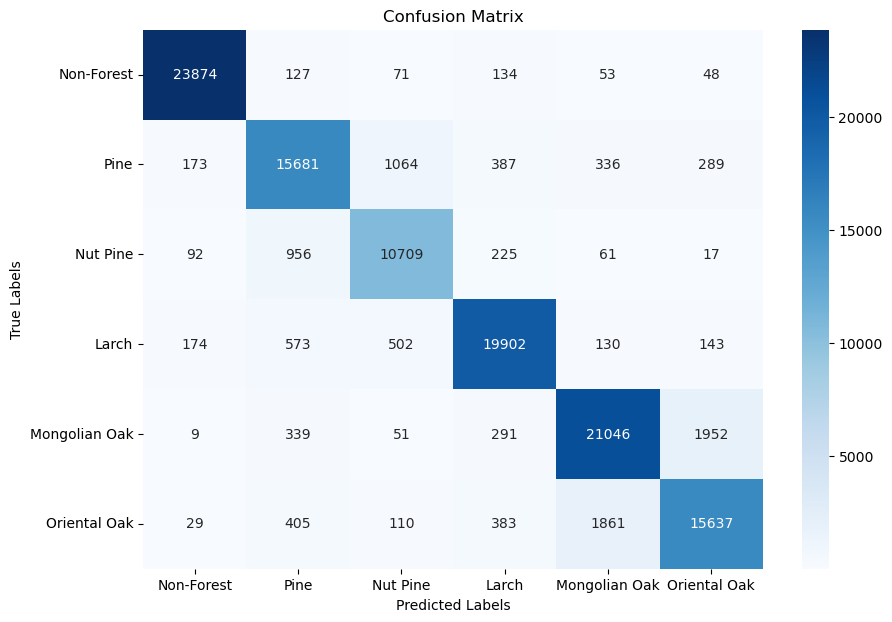

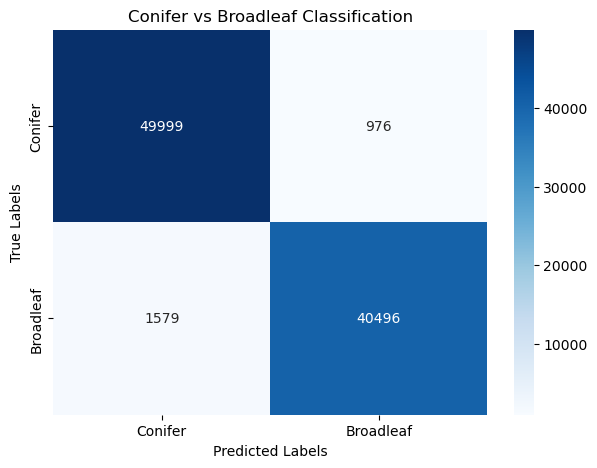

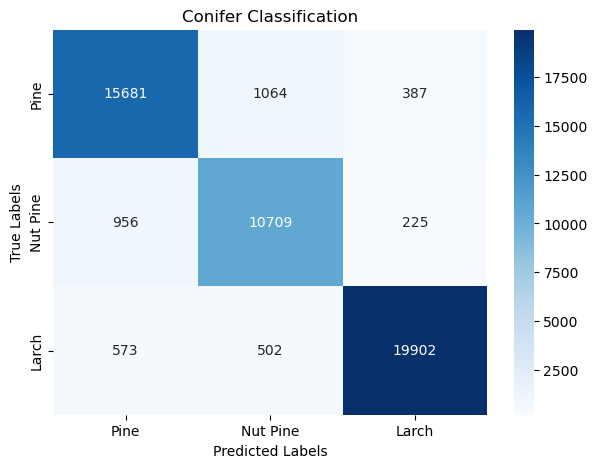

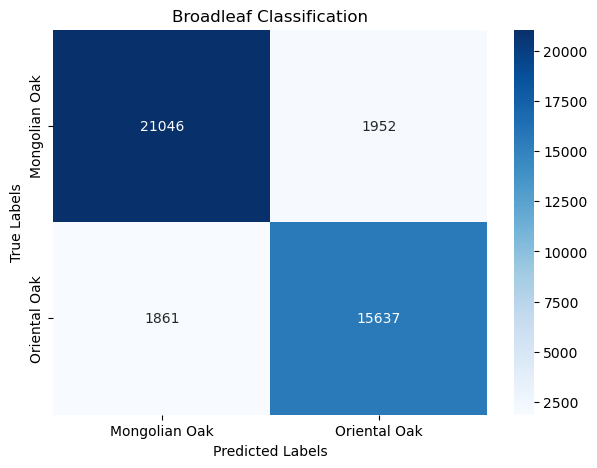

validation data


Evaluation Progress: 100%|██████████| 1163/1163 [00:05<00:00, 217.75it/s]


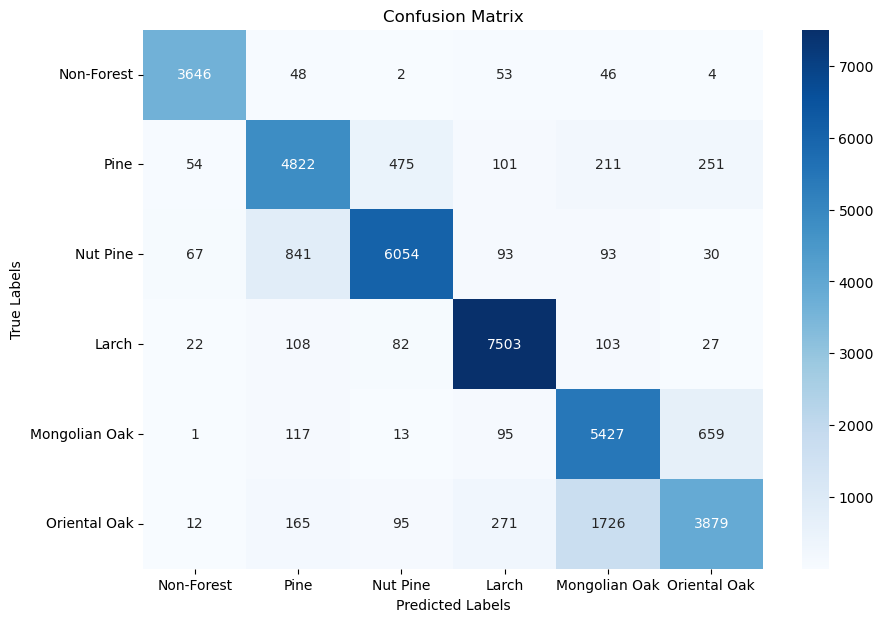

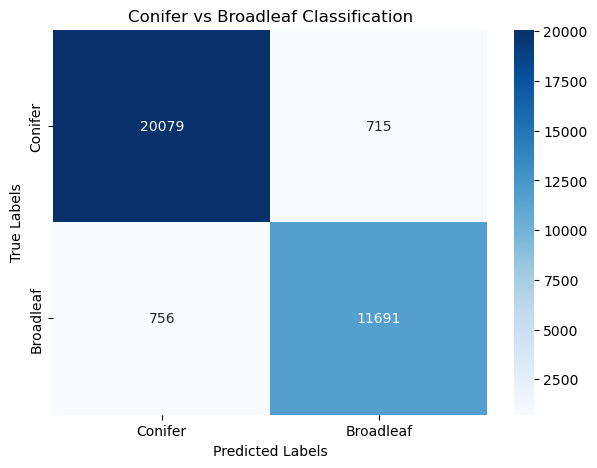

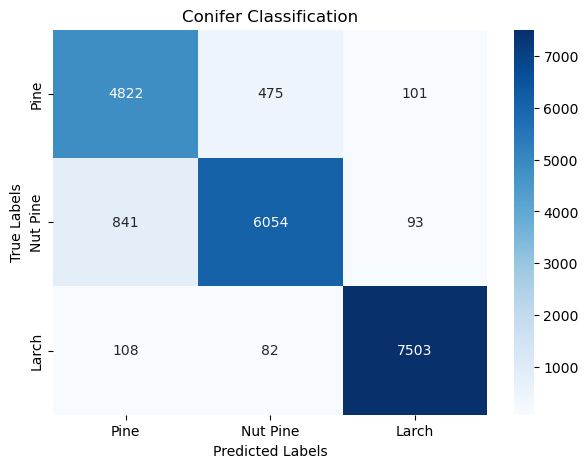

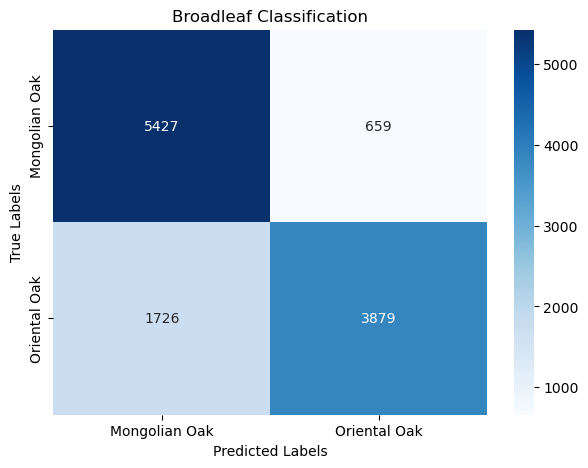

3
Training with patch size: 3


Epoch 1/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.88it/s]



Epoch [1/50], Train Loss: 0.5449, Train Accuracy: 79.15%, Val Loss: 0.5304, Val Accuracy: 81.62%



Epoch 2/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.48it/s]



Epoch [2/50], Train Loss: 0.4280, Train Accuracy: 83.94%, Val Loss: 0.8404, Val Accuracy: 71.02%



Epoch 3/50 - Validation: 100%|██████████| 1163/1163 [00:06<00:00, 191.84it/s]



Epoch [3/50], Train Loss: 0.3856, Train Accuracy: 85.47%, Val Loss: 0.6437, Val Accuracy: 79.96%



Epoch 4/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.92it/s]



Epoch [4/50], Train Loss: 0.3566, Train Accuracy: 86.68%, Val Loss: 0.5356, Val Accuracy: 81.94%



Epoch 5/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.41it/s]



Epoch [5/50], Train Loss: 0.3347, Train Accuracy: 87.46%, Val Loss: 0.4861, Val Accuracy: 84.68%



Epoch 6/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.07it/s]



Epoch [6/50], Train Loss: 0.3151, Train Accuracy: 88.30%, Val Loss: 0.5294, Val Accuracy: 84.08%



Epoch 7/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 197.16it/s]



Epoch [7/50], Train Loss: 0.2975, Train Accuracy: 89.08%, Val Loss: 0.7044, Val Accuracy: 81.05%



Epoch 8/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.53it/s]



Epoch [8/50], Train Loss: 0.2866, Train Accuracy: 89.45%, Val Loss: 0.5327, Val Accuracy: 83.25%



Epoch 9/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.82it/s]



Epoch [9/50], Train Loss: 0.2738, Train Accuracy: 89.87%, Val Loss: 0.5758, Val Accuracy: 82.86%



Epoch 10/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.38it/s]



Epoch [10/50], Train Loss: 0.2633, Train Accuracy: 90.31%, Val Loss: 0.6787, Val Accuracy: 80.89%



Epoch 11/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.98it/s]



Epoch [11/50], Train Loss: 0.2519, Train Accuracy: 90.75%, Val Loss: 0.5604, Val Accuracy: 81.98%



Epoch 12/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.75it/s]



Epoch [12/50], Train Loss: 0.2440, Train Accuracy: 90.98%, Val Loss: 0.4562, Val Accuracy: 85.98%



Epoch 13/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.82it/s]



Epoch [13/50], Train Loss: 0.2351, Train Accuracy: 91.43%, Val Loss: 0.6841, Val Accuracy: 79.87%



Epoch 14/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.48it/s]



Epoch [14/50], Train Loss: 0.2255, Train Accuracy: 91.73%, Val Loss: 0.4713, Val Accuracy: 86.05%



Epoch 15/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.05it/s]



Epoch [15/50], Train Loss: 0.2196, Train Accuracy: 91.94%, Val Loss: 0.5543, Val Accuracy: 84.36%



Epoch 16/50 - Validation: 100%|██████████| 1163/1163 [00:06<00:00, 192.19it/s]



Epoch [16/50], Train Loss: 0.2133, Train Accuracy: 92.19%, Val Loss: 0.6054, Val Accuracy: 83.72%



Epoch 17/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.47it/s]



Epoch [17/50], Train Loss: 0.2050, Train Accuracy: 92.43%, Val Loss: 0.6179, Val Accuracy: 83.87%



Epoch 18/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.11it/s]



Epoch [18/50], Train Loss: 0.2008, Train Accuracy: 92.66%, Val Loss: 0.6120, Val Accuracy: 83.31%



Epoch 19/50 - Validation: 100%|██████████| 1163/1163 [00:06<00:00, 192.27it/s]



Epoch [19/50], Train Loss: 0.1936, Train Accuracy: 92.92%, Val Loss: 0.6661, Val Accuracy: 80.09%



Epoch 20/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.01it/s]



Epoch [20/50], Train Loss: 0.1895, Train Accuracy: 93.04%, Val Loss: 0.5966, Val Accuracy: 84.37%



Epoch 21/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.05it/s]



Epoch [21/50], Train Loss: 0.1820, Train Accuracy: 93.35%, Val Loss: 0.5953, Val Accuracy: 83.28%



Epoch 22/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.92it/s]



Epoch [22/50], Train Loss: 0.1787, Train Accuracy: 93.39%, Val Loss: 0.5530, Val Accuracy: 85.30%



Epoch 23/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.65it/s]



Epoch [23/50], Train Loss: 0.1731, Train Accuracy: 93.57%, Val Loss: 0.6663, Val Accuracy: 83.40%



Epoch 24/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.87it/s]



Epoch [24/50], Train Loss: 0.1679, Train Accuracy: 93.83%, Val Loss: 0.5398, Val Accuracy: 85.53%



Epoch 25/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.68it/s]



Epoch [25/50], Train Loss: 0.1634, Train Accuracy: 93.91%, Val Loss: 0.6392, Val Accuracy: 83.48%



Epoch 26/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.09it/s]



Epoch [26/50], Train Loss: 0.1592, Train Accuracy: 94.12%, Val Loss: 0.6208, Val Accuracy: 83.83%



Epoch 27/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.72it/s]



Epoch [27/50], Train Loss: 0.1554, Train Accuracy: 94.19%, Val Loss: 0.6042, Val Accuracy: 84.19%



Epoch 28/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.07it/s]



Epoch [28/50], Train Loss: 0.1495, Train Accuracy: 94.51%, Val Loss: 0.7479, Val Accuracy: 81.36%



Epoch 29/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 194.16it/s]



Epoch [29/50], Train Loss: 0.1452, Train Accuracy: 94.66%, Val Loss: 0.6379, Val Accuracy: 84.75%



Epoch 30/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.16it/s]



Epoch [30/50], Train Loss: 0.1411, Train Accuracy: 94.77%, Val Loss: 0.6484, Val Accuracy: 83.90%



Epoch 31/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.11it/s]



Epoch [31/50], Train Loss: 0.1398, Train Accuracy: 94.83%, Val Loss: 0.6611, Val Accuracy: 83.59%



Epoch 32/50 - Validation: 100%|██████████| 1163/1163 [00:06<00:00, 192.37it/s]



Epoch [32/50], Train Loss: 0.1356, Train Accuracy: 94.93%, Val Loss: 0.7084, Val Accuracy: 83.83%



Epoch 33/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.05it/s]



Epoch [33/50], Train Loss: 0.1324, Train Accuracy: 95.06%, Val Loss: 0.6095, Val Accuracy: 84.97%



Epoch 34/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.33it/s]



Epoch [34/50], Train Loss: 0.1283, Train Accuracy: 95.27%, Val Loss: 0.5825, Val Accuracy: 85.96%



Epoch 35/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.90it/s]



Epoch [35/50], Train Loss: 0.1248, Train Accuracy: 95.35%, Val Loss: 0.6615, Val Accuracy: 84.53%



Epoch 36/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.21it/s]



Epoch [36/50], Train Loss: 0.1207, Train Accuracy: 95.48%, Val Loss: 0.6743, Val Accuracy: 84.47%



Epoch 37/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.08it/s]



Epoch [37/50], Train Loss: 0.1168, Train Accuracy: 95.64%, Val Loss: 0.6319, Val Accuracy: 84.79%



Epoch 38/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.20it/s]



Epoch [38/50], Train Loss: 0.1146, Train Accuracy: 95.69%, Val Loss: 0.7892, Val Accuracy: 82.02%



Epoch 39/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 195.94it/s]



Epoch [39/50], Train Loss: 0.1113, Train Accuracy: 95.90%, Val Loss: 0.6645, Val Accuracy: 85.29%



Epoch 40/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.69it/s]



Epoch [40/50], Train Loss: 0.1089, Train Accuracy: 95.90%, Val Loss: 0.6936, Val Accuracy: 84.74%



Epoch 41/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.40it/s]



Epoch [41/50], Train Loss: 0.1050, Train Accuracy: 96.07%, Val Loss: 0.6959, Val Accuracy: 84.46%



Epoch 42/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.64it/s]



Epoch [42/50], Train Loss: 0.1019, Train Accuracy: 96.18%, Val Loss: 0.6639, Val Accuracy: 85.01%



Epoch 43/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.45it/s]



Epoch [43/50], Train Loss: 0.1010, Train Accuracy: 96.23%, Val Loss: 0.6489, Val Accuracy: 84.88%



Epoch 44/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.09it/s]



Epoch [44/50], Train Loss: 0.0972, Train Accuracy: 96.38%, Val Loss: 0.8781, Val Accuracy: 81.43%



Epoch 45/50 - Validation: 100%|██████████| 1163/1163 [00:06<00:00, 192.63it/s]



Epoch [45/50], Train Loss: 0.0950, Train Accuracy: 96.44%, Val Loss: 0.6895, Val Accuracy: 85.69%



Epoch 46/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.36it/s]



Epoch [46/50], Train Loss: 0.0921, Train Accuracy: 96.54%, Val Loss: 0.7739, Val Accuracy: 83.78%



Epoch 47/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.42it/s]



Epoch [47/50], Train Loss: 0.0898, Train Accuracy: 96.61%, Val Loss: 0.7415, Val Accuracy: 84.93%



Epoch 48/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.69it/s]



Epoch [48/50], Train Loss: 0.0885, Train Accuracy: 96.67%, Val Loss: 0.7859, Val Accuracy: 84.11%



Epoch 49/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.62it/s]



Epoch [49/50], Train Loss: 0.0835, Train Accuracy: 96.86%, Val Loss: 0.7892, Val Accuracy: 83.78%



Epoch 50/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 196.63it/s]



Epoch [50/50], Train Loss: 0.0830, Train Accuracy: 96.92%, Val Loss: 0.8480, Val Accuracy: 82.00%

train data


Evaluation Progress: 100%|██████████| 3683/3683 [00:18<00:00, 197.09it/s]


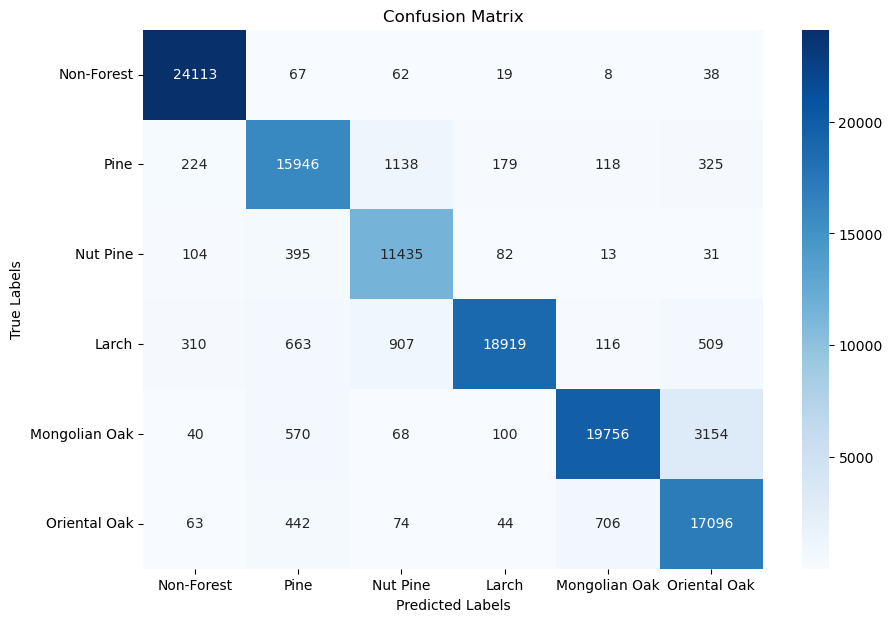

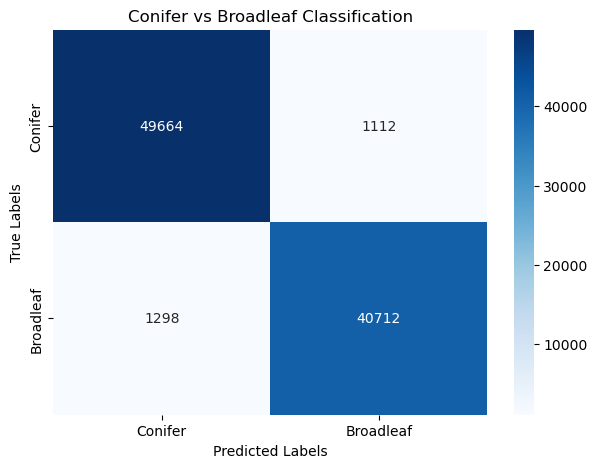

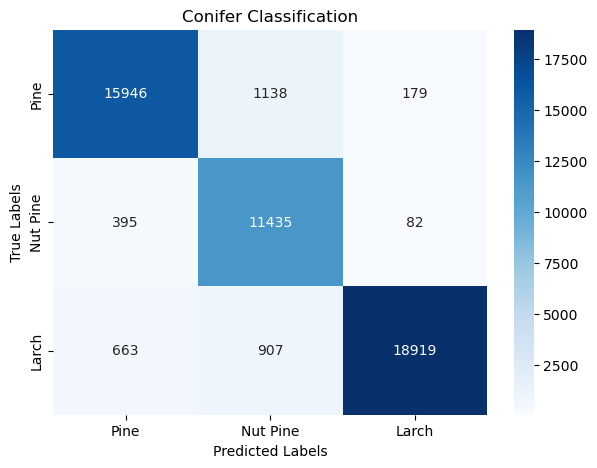

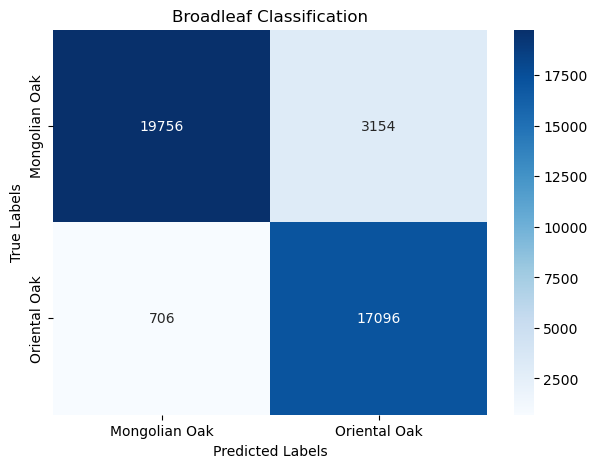

validation data


Evaluation Progress: 100%|██████████| 1163/1163 [00:05<00:00, 196.11it/s]


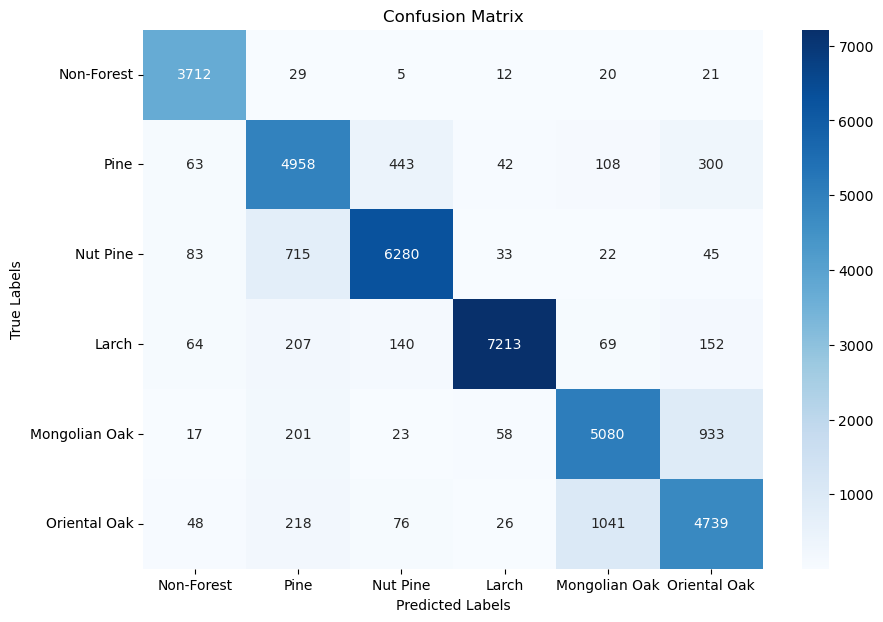

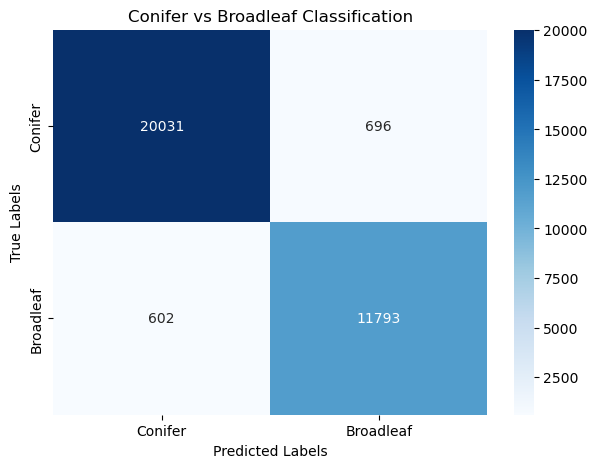

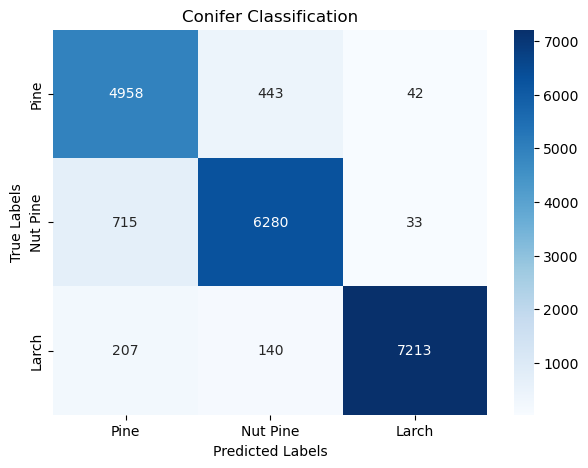

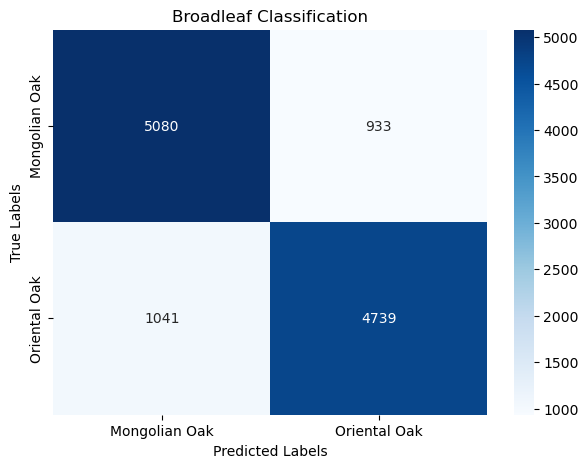

5
Training with patch size: 5


Epoch 1/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 187.81it/s]



Epoch [1/50], Train Loss: 0.5242, Train Accuracy: 80.03%, Val Loss: 0.5158, Val Accuracy: 81.18%



Epoch 2/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.78it/s]



Epoch [2/50], Train Loss: 0.4014, Train Accuracy: 85.04%, Val Loss: 0.5806, Val Accuracy: 80.44%



Epoch 3/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.58it/s]



Epoch [3/50], Train Loss: 0.3540, Train Accuracy: 86.94%, Val Loss: 0.5874, Val Accuracy: 80.45%



Epoch 4/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 185.39it/s]



Epoch [4/50], Train Loss: 0.3255, Train Accuracy: 87.90%, Val Loss: 0.4992, Val Accuracy: 83.46%



Epoch 5/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.92it/s]



Epoch [5/50], Train Loss: 0.2999, Train Accuracy: 88.91%, Val Loss: 0.5318, Val Accuracy: 83.61%



Epoch 6/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 190.27it/s]



Epoch [6/50], Train Loss: 0.2826, Train Accuracy: 89.52%, Val Loss: 0.5743, Val Accuracy: 81.12%



Epoch 7/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.92it/s]



Epoch [7/50], Train Loss: 0.2670, Train Accuracy: 90.17%, Val Loss: 0.5333, Val Accuracy: 84.22%



Epoch 8/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.84it/s]



Epoch [8/50], Train Loss: 0.2541, Train Accuracy: 90.65%, Val Loss: 0.6844, Val Accuracy: 82.06%



Epoch 9/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.85it/s]



Epoch [9/50], Train Loss: 0.2440, Train Accuracy: 91.01%, Val Loss: 0.5307, Val Accuracy: 85.42%



Epoch 10/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.57it/s]



Epoch [10/50], Train Loss: 0.2346, Train Accuracy: 91.39%, Val Loss: 0.5676, Val Accuracy: 84.91%



Epoch 11/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 187.91it/s]



Epoch [11/50], Train Loss: 0.2256, Train Accuracy: 91.74%, Val Loss: 0.6123, Val Accuracy: 81.74%



Epoch 12/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.80it/s]



Epoch [12/50], Train Loss: 0.2173, Train Accuracy: 92.02%, Val Loss: 0.5648, Val Accuracy: 84.02%



Epoch 13/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.98it/s]



Epoch [13/50], Train Loss: 0.2102, Train Accuracy: 92.24%, Val Loss: 0.5316, Val Accuracy: 86.13%



Epoch 14/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.84it/s]



Epoch [14/50], Train Loss: 0.2017, Train Accuracy: 92.56%, Val Loss: 0.5403, Val Accuracy: 84.10%



Epoch 15/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 185.93it/s]



Epoch [15/50], Train Loss: 0.1945, Train Accuracy: 92.86%, Val Loss: 0.6866, Val Accuracy: 81.94%



Epoch 16/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.92it/s]



Epoch [16/50], Train Loss: 0.1916, Train Accuracy: 92.89%, Val Loss: 0.5923, Val Accuracy: 84.56%



Epoch 17/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.71it/s]



Epoch [17/50], Train Loss: 0.1855, Train Accuracy: 93.21%, Val Loss: 0.5599, Val Accuracy: 85.73%



Epoch 18/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.86it/s]



Epoch [18/50], Train Loss: 0.1800, Train Accuracy: 93.45%, Val Loss: 0.5642, Val Accuracy: 84.26%



Epoch 19/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.96it/s]



Epoch [19/50], Train Loss: 0.1727, Train Accuracy: 93.59%, Val Loss: 0.7023, Val Accuracy: 82.03%



Epoch 20/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.82it/s]



Epoch [20/50], Train Loss: 0.1693, Train Accuracy: 93.76%, Val Loss: 0.6684, Val Accuracy: 81.30%



Epoch 21/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.92it/s]



Epoch [21/50], Train Loss: 0.1632, Train Accuracy: 93.93%, Val Loss: 0.5379, Val Accuracy: 85.59%



Epoch 22/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 186.29it/s]



Epoch [22/50], Train Loss: 0.1584, Train Accuracy: 94.09%, Val Loss: 0.6409, Val Accuracy: 81.66%



Epoch 23/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.98it/s]



Epoch [23/50], Train Loss: 0.1552, Train Accuracy: 94.22%, Val Loss: 0.4962, Val Accuracy: 87.61%



Epoch 24/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.81it/s]



Epoch [24/50], Train Loss: 0.1521, Train Accuracy: 94.31%, Val Loss: 0.5599, Val Accuracy: 85.73%



Epoch 25/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.54it/s]



Epoch [25/50], Train Loss: 0.1479, Train Accuracy: 94.54%, Val Loss: 0.5772, Val Accuracy: 85.17%



Epoch 26/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 186.96it/s]



Epoch [26/50], Train Loss: 0.1417, Train Accuracy: 94.77%, Val Loss: 0.5589, Val Accuracy: 84.96%



Epoch 27/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.48it/s]



Epoch [27/50], Train Loss: 0.1397, Train Accuracy: 94.84%, Val Loss: 0.5949, Val Accuracy: 84.20%



Epoch 28/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 184.08it/s]



Epoch [28/50], Train Loss: 0.1359, Train Accuracy: 94.96%, Val Loss: 0.6042, Val Accuracy: 85.23%



Epoch 29/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 187.59it/s]



Epoch [29/50], Train Loss: 0.1294, Train Accuracy: 95.21%, Val Loss: 0.6795, Val Accuracy: 83.80%



Epoch 30/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 187.71it/s]



Epoch [30/50], Train Loss: 0.1280, Train Accuracy: 95.23%, Val Loss: 0.8431, Val Accuracy: 80.05%



Epoch 31/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 187.66it/s]



Epoch [31/50], Train Loss: 0.1250, Train Accuracy: 95.36%, Val Loss: 0.6498, Val Accuracy: 83.93%



Epoch 32/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 188.21it/s]



Epoch [32/50], Train Loss: 0.1218, Train Accuracy: 95.46%, Val Loss: 0.6208, Val Accuracy: 85.29%



Epoch 33/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.45it/s]



Epoch [33/50], Train Loss: 0.1187, Train Accuracy: 95.62%, Val Loss: 0.5887, Val Accuracy: 85.04%



Epoch 34/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.57it/s]



Epoch [34/50], Train Loss: 0.1170, Train Accuracy: 95.66%, Val Loss: 0.7494, Val Accuracy: 82.91%



Epoch 35/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.79it/s]



Epoch [35/50], Train Loss: 0.1137, Train Accuracy: 95.73%, Val Loss: 0.5779, Val Accuracy: 86.05%



Epoch 36/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.56it/s]



Epoch [36/50], Train Loss: 0.1093, Train Accuracy: 95.95%, Val Loss: 0.7250, Val Accuracy: 84.07%



Epoch 37/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 185.13it/s]



Epoch [37/50], Train Loss: 0.1098, Train Accuracy: 96.02%, Val Loss: 0.7646, Val Accuracy: 84.06%



Epoch 38/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.76it/s]



Epoch [38/50], Train Loss: 0.1062, Train Accuracy: 96.11%, Val Loss: 0.7066, Val Accuracy: 84.06%



Epoch 39/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.85it/s]



Epoch [39/50], Train Loss: 0.1040, Train Accuracy: 96.14%, Val Loss: 0.7170, Val Accuracy: 84.78%



Epoch 40/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.65it/s]



Epoch [40/50], Train Loss: 0.1010, Train Accuracy: 96.24%, Val Loss: 0.7126, Val Accuracy: 84.55%



Epoch 41/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 187.86it/s]



Epoch [41/50], Train Loss: 0.0995, Train Accuracy: 96.31%, Val Loss: 0.6300, Val Accuracy: 85.86%



Epoch 42/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.09it/s]



Epoch [42/50], Train Loss: 0.0962, Train Accuracy: 96.43%, Val Loss: 0.7532, Val Accuracy: 84.41%



Epoch 43/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.70it/s]



Epoch [43/50], Train Loss: 0.0934, Train Accuracy: 96.49%, Val Loss: 0.6871, Val Accuracy: 84.44%



Epoch 44/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 188.41it/s]



Epoch [44/50], Train Loss: 0.0920, Train Accuracy: 96.61%, Val Loss: 0.7005, Val Accuracy: 84.65%



Epoch 45/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 190.22it/s]



Epoch [45/50], Train Loss: 0.0895, Train Accuracy: 96.69%, Val Loss: 0.7617, Val Accuracy: 83.51%



Epoch 46/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.53it/s]



Epoch [46/50], Train Loss: 0.0886, Train Accuracy: 96.67%, Val Loss: 0.9013, Val Accuracy: 81.69%



Epoch 47/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.66it/s]



Epoch [47/50], Train Loss: 0.0854, Train Accuracy: 96.85%, Val Loss: 0.7956, Val Accuracy: 84.25%



Epoch 48/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 185.50it/s]



Epoch [48/50], Train Loss: 0.0849, Train Accuracy: 96.82%, Val Loss: 0.7496, Val Accuracy: 85.40%



Epoch 49/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.79it/s]



Epoch [49/50], Train Loss: 0.0824, Train Accuracy: 96.93%, Val Loss: 0.9392, Val Accuracy: 81.54%



Epoch 50/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 189.30it/s]



Epoch [50/50], Train Loss: 0.0802, Train Accuracy: 97.05%, Val Loss: 0.7415, Val Accuracy: 85.35%

train data


Evaluation Progress: 100%|██████████| 3662/3662 [00:19<00:00, 190.53it/s]


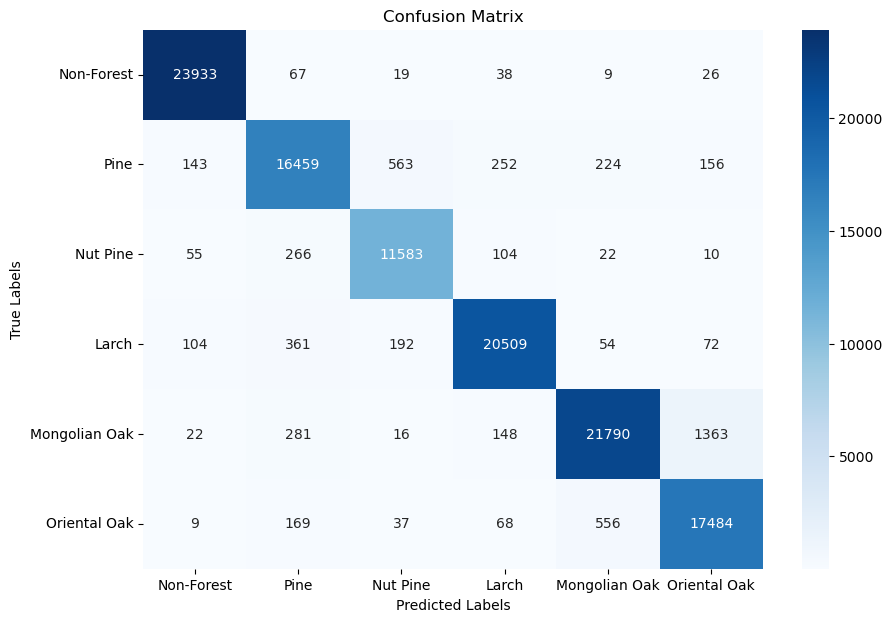

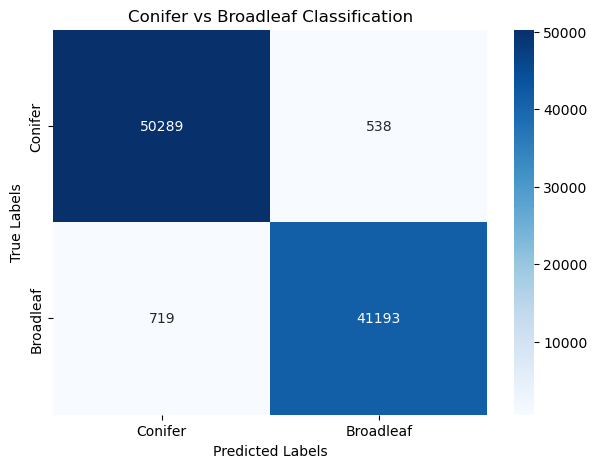

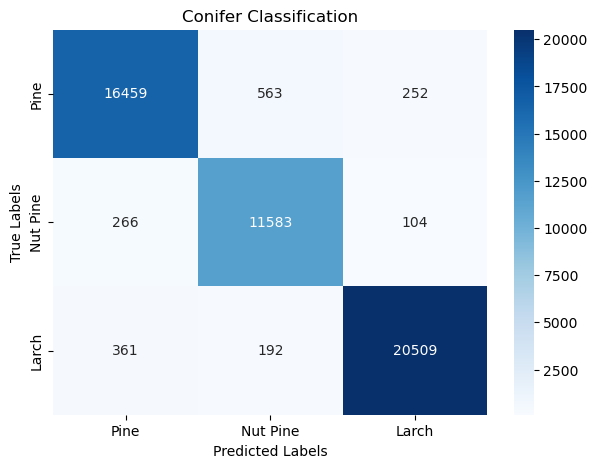

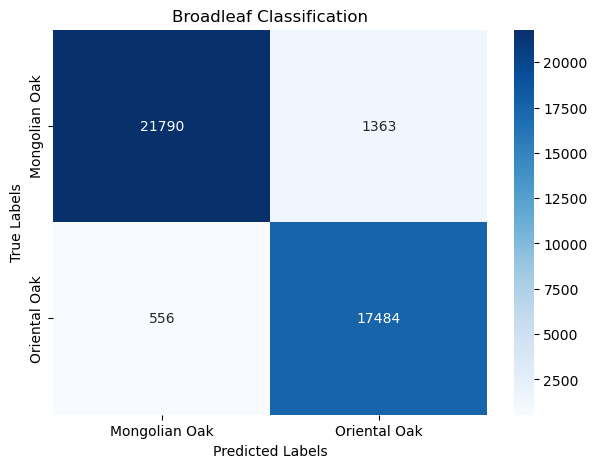

validation data


Evaluation Progress: 100%|██████████| 1159/1159 [00:06<00:00, 188.96it/s]


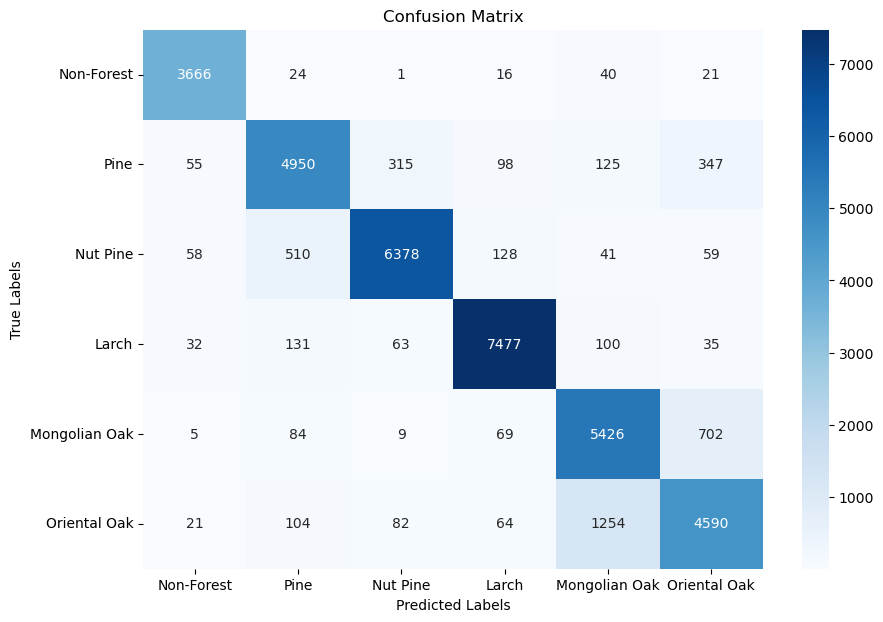

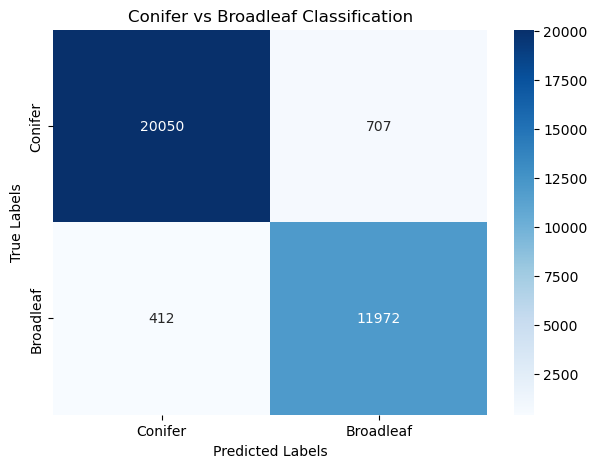

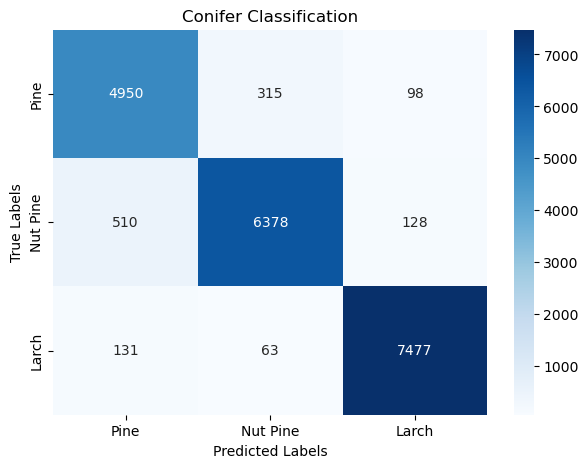

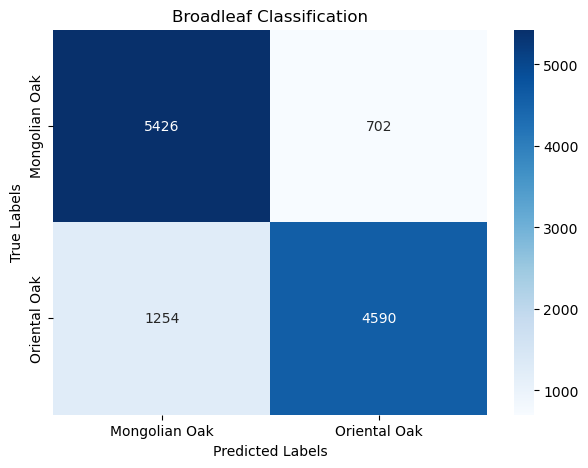

7
Training with patch size: 7


Epoch 1/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 172.35it/s]



Epoch [1/50], Train Loss: 0.5024, Train Accuracy: 81.10%, Val Loss: 0.8238, Val Accuracy: 72.97%



Epoch 2/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.87it/s]



Epoch [2/50], Train Loss: 0.3830, Train Accuracy: 85.92%, Val Loss: 0.6369, Val Accuracy: 77.97%



Epoch 3/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.16it/s]



Epoch [3/50], Train Loss: 0.3398, Train Accuracy: 87.35%, Val Loss: 0.5320, Val Accuracy: 80.83%



Epoch 4/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.55it/s]



Epoch [4/50], Train Loss: 0.3099, Train Accuracy: 88.52%, Val Loss: 0.6330, Val Accuracy: 79.89%



Epoch 5/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.67it/s]



Epoch [5/50], Train Loss: 0.2881, Train Accuracy: 89.29%, Val Loss: 0.5651, Val Accuracy: 81.55%



Epoch 6/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.67it/s]



Epoch [6/50], Train Loss: 0.2687, Train Accuracy: 90.03%, Val Loss: 0.6240, Val Accuracy: 81.16%



Epoch 7/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.78it/s]



Epoch [7/50], Train Loss: 0.2530, Train Accuracy: 90.62%, Val Loss: 0.5996, Val Accuracy: 81.54%



Epoch 8/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.59it/s]



Epoch [8/50], Train Loss: 0.2389, Train Accuracy: 91.20%, Val Loss: 0.7802, Val Accuracy: 79.58%



Epoch 9/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.81it/s]



Epoch [9/50], Train Loss: 0.2268, Train Accuracy: 91.63%, Val Loss: 0.5539, Val Accuracy: 85.06%



Epoch 10/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.79it/s]



Epoch [10/50], Train Loss: 0.2158, Train Accuracy: 92.10%, Val Loss: 0.5849, Val Accuracy: 82.54%



Epoch 11/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.81it/s]



Epoch [11/50], Train Loss: 0.2077, Train Accuracy: 92.40%, Val Loss: 0.5336, Val Accuracy: 84.99%



Epoch 12/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.55it/s]



Epoch [12/50], Train Loss: 0.1991, Train Accuracy: 92.74%, Val Loss: 0.5254, Val Accuracy: 85.81%



Epoch 13/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.59it/s]



Epoch [13/50], Train Loss: 0.1906, Train Accuracy: 92.89%, Val Loss: 0.5945, Val Accuracy: 84.65%



Epoch 14/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.49it/s]



Epoch [14/50], Train Loss: 0.1843, Train Accuracy: 93.23%, Val Loss: 0.6164, Val Accuracy: 82.51%



Epoch 15/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.59it/s]



Epoch [15/50], Train Loss: 0.1791, Train Accuracy: 93.47%, Val Loss: 0.6903, Val Accuracy: 83.76%



Epoch 16/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.27it/s]



Epoch [16/50], Train Loss: 0.1713, Train Accuracy: 93.71%, Val Loss: 0.4924, Val Accuracy: 86.31%



Epoch 17/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.24it/s]



Epoch [17/50], Train Loss: 0.1658, Train Accuracy: 93.96%, Val Loss: 0.6173, Val Accuracy: 83.70%



Epoch 18/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.11it/s]



Epoch [18/50], Train Loss: 0.1592, Train Accuracy: 94.17%, Val Loss: 0.6113, Val Accuracy: 84.90%



Epoch 19/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.13it/s]



Epoch [19/50], Train Loss: 0.1538, Train Accuracy: 94.31%, Val Loss: 0.6075, Val Accuracy: 84.48%



Epoch 20/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.04it/s]



Epoch [20/50], Train Loss: 0.1488, Train Accuracy: 94.48%, Val Loss: 0.7987, Val Accuracy: 81.56%



Epoch 21/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 169.15it/s]



Epoch [21/50], Train Loss: 0.1451, Train Accuracy: 94.59%, Val Loss: 0.5948, Val Accuracy: 86.54%



Epoch 22/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 171.29it/s]



Epoch [22/50], Train Loss: 0.1385, Train Accuracy: 94.89%, Val Loss: 0.5308, Val Accuracy: 85.84%



Epoch 23/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.04it/s]



Epoch [23/50], Train Loss: 0.1356, Train Accuracy: 94.94%, Val Loss: 0.6205, Val Accuracy: 84.53%



Epoch 24/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.32it/s]



Epoch [24/50], Train Loss: 0.1312, Train Accuracy: 95.18%, Val Loss: 0.5927, Val Accuracy: 85.33%



Epoch 25/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 172.51it/s]



Epoch [25/50], Train Loss: 0.1288, Train Accuracy: 95.23%, Val Loss: 0.6951, Val Accuracy: 83.13%



Epoch 26/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 170.94it/s]



Epoch [26/50], Train Loss: 0.1252, Train Accuracy: 95.42%, Val Loss: 0.6980, Val Accuracy: 84.69%



Epoch 27/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 172.84it/s]



Epoch [27/50], Train Loss: 0.1192, Train Accuracy: 95.62%, Val Loss: 0.6639, Val Accuracy: 84.17%



Epoch 28/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.13it/s]



Epoch [28/50], Train Loss: 0.1162, Train Accuracy: 95.73%, Val Loss: 0.6624, Val Accuracy: 84.10%



Epoch 29/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.20it/s]



Epoch [29/50], Train Loss: 0.1139, Train Accuracy: 95.79%, Val Loss: 0.6657, Val Accuracy: 84.73%



Epoch 30/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.07it/s]



Epoch [30/50], Train Loss: 0.1101, Train Accuracy: 95.91%, Val Loss: 0.6200, Val Accuracy: 85.33%



Epoch 31/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.50it/s]



Epoch [31/50], Train Loss: 0.1073, Train Accuracy: 95.99%, Val Loss: 0.6998, Val Accuracy: 84.39%



Epoch 32/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 172.99it/s]



Epoch [32/50], Train Loss: 0.1047, Train Accuracy: 96.16%, Val Loss: 0.6677, Val Accuracy: 84.89%



Epoch 33/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.77it/s]



Epoch [33/50], Train Loss: 0.1016, Train Accuracy: 96.22%, Val Loss: 0.8140, Val Accuracy: 83.43%



Epoch 34/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.18it/s]



Epoch [34/50], Train Loss: 0.0981, Train Accuracy: 96.29%, Val Loss: 0.6064, Val Accuracy: 85.88%



Epoch 35/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.34it/s]



Epoch [35/50], Train Loss: 0.0965, Train Accuracy: 96.44%, Val Loss: 0.7448, Val Accuracy: 84.25%



Epoch 36/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.25it/s]



Epoch [36/50], Train Loss: 0.0947, Train Accuracy: 96.55%, Val Loss: 0.6757, Val Accuracy: 85.46%



Epoch 37/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.15it/s]



Epoch [37/50], Train Loss: 0.0920, Train Accuracy: 96.55%, Val Loss: 0.8035, Val Accuracy: 83.71%



Epoch 38/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 172.59it/s]



Epoch [38/50], Train Loss: 0.0894, Train Accuracy: 96.67%, Val Loss: 0.7548, Val Accuracy: 85.71%



Epoch 39/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.19it/s]



Epoch [39/50], Train Loss: 0.0869, Train Accuracy: 96.77%, Val Loss: 0.7455, Val Accuracy: 84.87%



Epoch 40/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.75it/s]



Epoch [40/50], Train Loss: 0.0861, Train Accuracy: 96.85%, Val Loss: 0.6342, Val Accuracy: 86.01%



Epoch 41/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.51it/s]



Epoch [41/50], Train Loss: 0.0831, Train Accuracy: 96.93%, Val Loss: 0.5696, Val Accuracy: 87.00%



Epoch 42/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.74it/s]



Epoch [42/50], Train Loss: 0.0815, Train Accuracy: 97.02%, Val Loss: 0.7408, Val Accuracy: 85.64%



Epoch 43/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 172.12it/s]



Epoch [43/50], Train Loss: 0.0799, Train Accuracy: 97.02%, Val Loss: 0.7216, Val Accuracy: 84.87%



Epoch 44/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 171.98it/s]



Epoch [44/50], Train Loss: 0.0768, Train Accuracy: 97.12%, Val Loss: 0.8283, Val Accuracy: 85.23%



Epoch 45/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 170.43it/s]



Epoch [45/50], Train Loss: 0.0749, Train Accuracy: 97.25%, Val Loss: 0.8266, Val Accuracy: 83.58%



Epoch 46/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 171.00it/s]



Epoch [46/50], Train Loss: 0.0730, Train Accuracy: 97.31%, Val Loss: 0.8332, Val Accuracy: 83.94%



Epoch 47/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.30it/s]



Epoch [47/50], Train Loss: 0.0708, Train Accuracy: 97.41%, Val Loss: 0.8355, Val Accuracy: 82.83%



Epoch 48/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.96it/s]



Epoch [48/50], Train Loss: 0.0692, Train Accuracy: 97.45%, Val Loss: 0.8205, Val Accuracy: 84.50%



Epoch 49/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.55it/s]



Epoch [49/50], Train Loss: 0.0699, Train Accuracy: 97.46%, Val Loss: 0.9709, Val Accuracy: 83.97%



Epoch 50/50 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.73it/s]



Epoch [50/50], Train Loss: 0.0664, Train Accuracy: 97.52%, Val Loss: 0.9537, Val Accuracy: 84.11%

train data


Evaluation Progress: 100%|██████████| 3662/3662 [00:21<00:00, 174.04it/s]


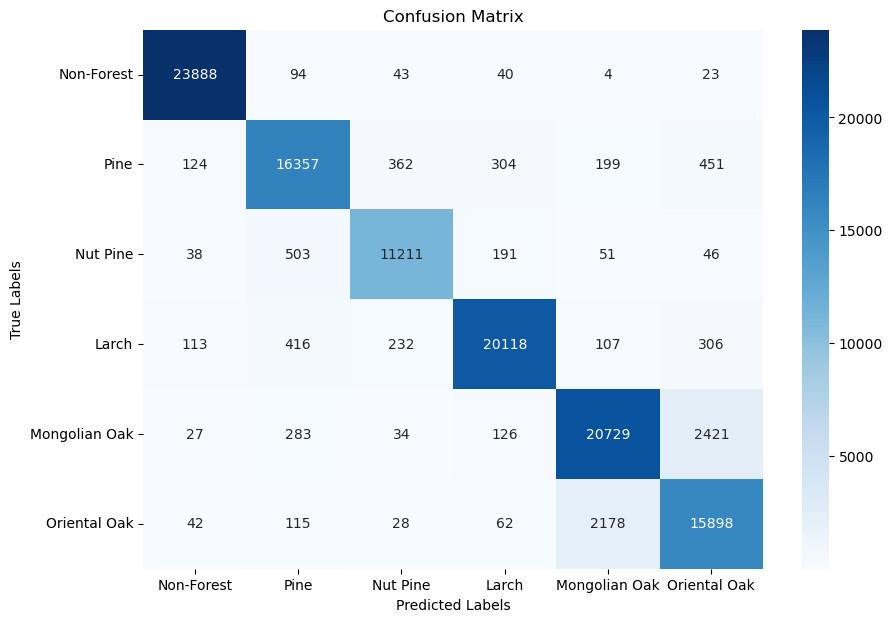

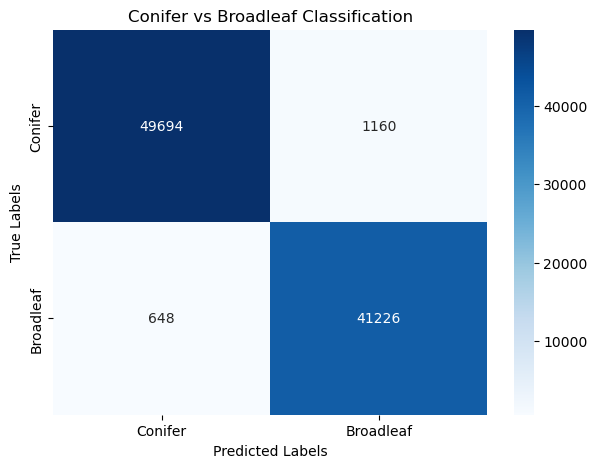

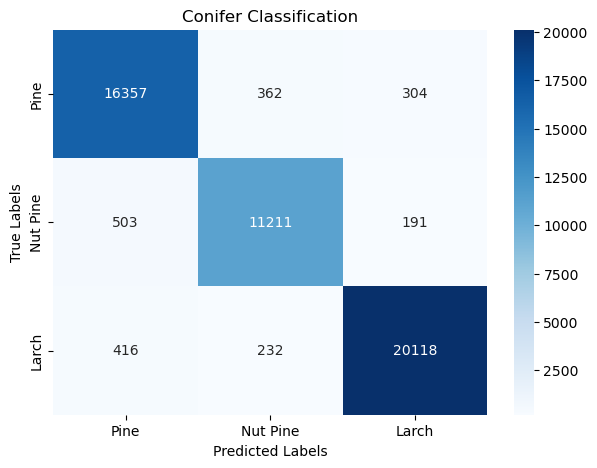

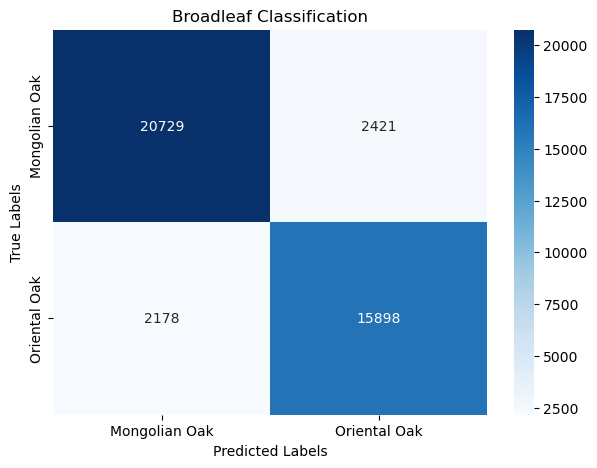

validation data


Evaluation Progress: 100%|██████████| 1159/1159 [00:06<00:00, 172.60it/s]


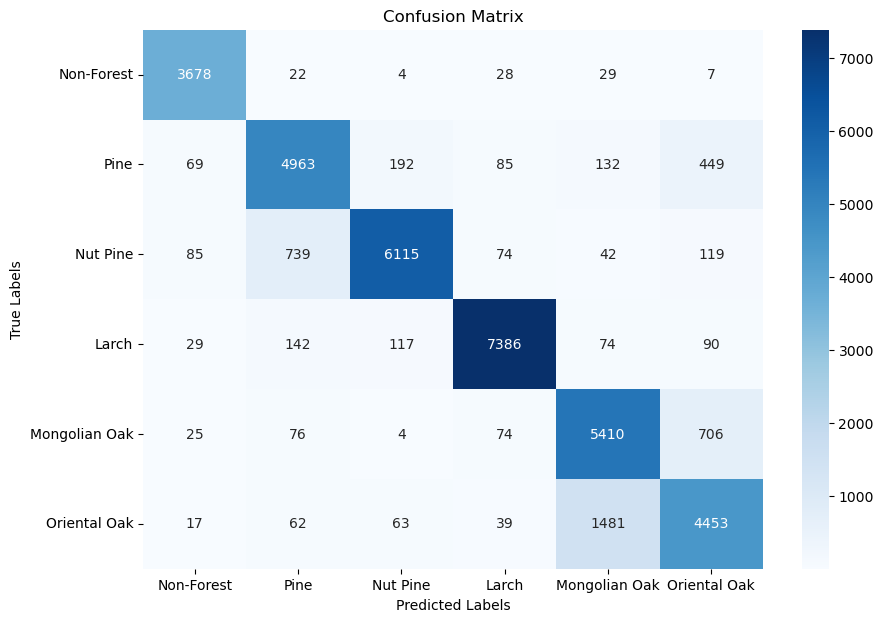

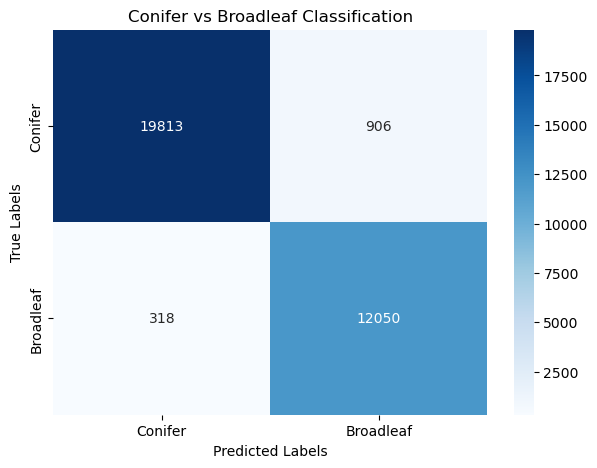

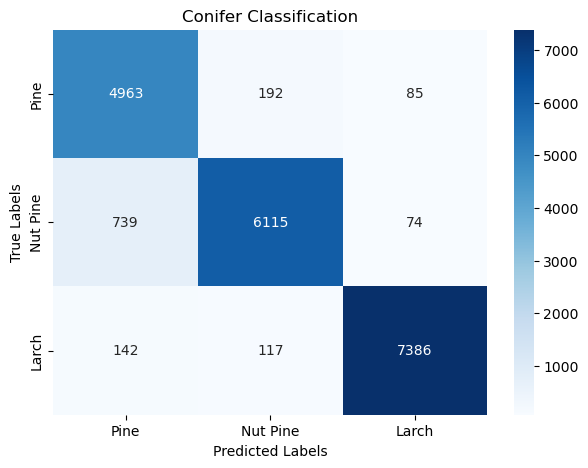

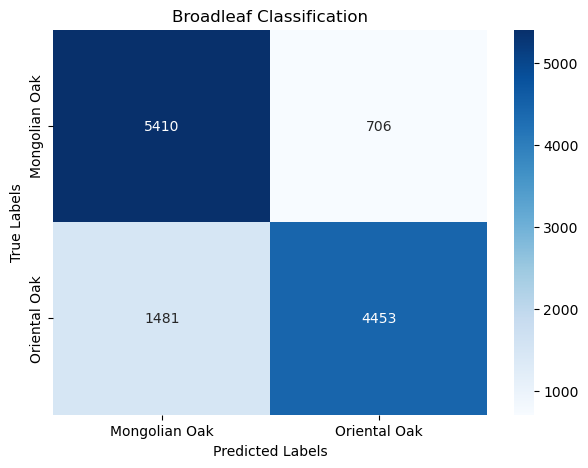

9
Training with patch size: 9


Epoch 1/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.37it/s]



Epoch [1/50], Train Loss: 0.5060, Train Accuracy: 81.07%, Val Loss: 0.7990, Val Accuracy: 74.80%



Epoch 2/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 161.80it/s]



Epoch [2/50], Train Loss: 0.3718, Train Accuracy: 86.24%, Val Loss: 1.1602, Val Accuracy: 72.97%



Epoch 3/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 163.24it/s]



Epoch [3/50], Train Loss: 0.3262, Train Accuracy: 87.88%, Val Loss: 0.7853, Val Accuracy: 74.46%



Epoch 4/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 163.40it/s]



Epoch [4/50], Train Loss: 0.2970, Train Accuracy: 88.92%, Val Loss: 0.8062, Val Accuracy: 74.09%



Epoch 5/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.34it/s]



Epoch [5/50], Train Loss: 0.2716, Train Accuracy: 90.00%, Val Loss: 0.5608, Val Accuracy: 85.29%



Epoch 6/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.32it/s]



Epoch [6/50], Train Loss: 0.2545, Train Accuracy: 90.66%, Val Loss: 0.5664, Val Accuracy: 85.32%



Epoch 7/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 163.60it/s]



Epoch [7/50], Train Loss: 0.2387, Train Accuracy: 91.25%, Val Loss: 0.5336, Val Accuracy: 83.20%



Epoch 8/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.33it/s]



Epoch [8/50], Train Loss: 0.2274, Train Accuracy: 91.70%, Val Loss: 0.4276, Val Accuracy: 87.90%



Epoch 9/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.47it/s]



Epoch [9/50], Train Loss: 0.2176, Train Accuracy: 92.02%, Val Loss: 0.5285, Val Accuracy: 84.11%



Epoch 10/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.20it/s]



Epoch [10/50], Train Loss: 0.2073, Train Accuracy: 92.46%, Val Loss: 0.8177, Val Accuracy: 75.69%



Epoch 11/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.34it/s]



Epoch [11/50], Train Loss: 0.1986, Train Accuracy: 92.76%, Val Loss: 0.5635, Val Accuracy: 84.94%



Epoch 12/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 161.57it/s]



Epoch [12/50], Train Loss: 0.1898, Train Accuracy: 93.09%, Val Loss: 0.7244, Val Accuracy: 80.67%



Epoch 13/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.83it/s]



Epoch [13/50], Train Loss: 0.1837, Train Accuracy: 93.28%, Val Loss: 0.7207, Val Accuracy: 80.69%



Epoch 14/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.93it/s]



Epoch [14/50], Train Loss: 0.1795, Train Accuracy: 93.38%, Val Loss: 0.5274, Val Accuracy: 86.22%



Epoch 15/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 163.08it/s]



Epoch [15/50], Train Loss: 0.1703, Train Accuracy: 93.76%, Val Loss: 0.6353, Val Accuracy: 83.92%



Epoch 16/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.18it/s]



Epoch [16/50], Train Loss: 0.1661, Train Accuracy: 93.89%, Val Loss: 0.4762, Val Accuracy: 87.39%



Epoch 17/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 161.55it/s]



Epoch [17/50], Train Loss: 0.1602, Train Accuracy: 94.09%, Val Loss: 0.8606, Val Accuracy: 79.70%



Epoch 18/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.83it/s]



Epoch [18/50], Train Loss: 0.1546, Train Accuracy: 94.32%, Val Loss: 0.5970, Val Accuracy: 85.78%



Epoch 19/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.94it/s]



Epoch [19/50], Train Loss: 0.1499, Train Accuracy: 94.53%, Val Loss: 0.6696, Val Accuracy: 84.43%



Epoch 20/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 163.28it/s]



Epoch [20/50], Train Loss: 0.1452, Train Accuracy: 94.69%, Val Loss: 0.5518, Val Accuracy: 85.81%



Epoch 21/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 163.19it/s]



Epoch [21/50], Train Loss: 0.1420, Train Accuracy: 94.79%, Val Loss: 0.5070, Val Accuracy: 86.20%



Epoch 22/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 163.32it/s]



Epoch [22/50], Train Loss: 0.1367, Train Accuracy: 94.94%, Val Loss: 0.6011, Val Accuracy: 86.49%



Epoch 23/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.38it/s]



Epoch [23/50], Train Loss: 0.1327, Train Accuracy: 95.15%, Val Loss: 0.9071, Val Accuracy: 80.09%



Epoch 24/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 163.17it/s]



Epoch [24/50], Train Loss: 0.1285, Train Accuracy: 95.25%, Val Loss: 0.6160, Val Accuracy: 85.70%



Epoch 25/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 163.65it/s]



Epoch [25/50], Train Loss: 0.1251, Train Accuracy: 95.43%, Val Loss: 0.6877, Val Accuracy: 82.60%



Epoch 26/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.97it/s]



Epoch [26/50], Train Loss: 0.1218, Train Accuracy: 95.51%, Val Loss: 0.6311, Val Accuracy: 85.26%



Epoch 27/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 163.10it/s]



Epoch [27/50], Train Loss: 0.1173, Train Accuracy: 95.66%, Val Loss: 0.6952, Val Accuracy: 84.06%



Epoch 28/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 163.73it/s]



Epoch [28/50], Train Loss: 0.1148, Train Accuracy: 95.84%, Val Loss: 0.6803, Val Accuracy: 85.63%



Epoch 29/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 163.30it/s]



Epoch [29/50], Train Loss: 0.1124, Train Accuracy: 95.84%, Val Loss: 0.8268, Val Accuracy: 83.76%



Epoch 30/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.88it/s]



Epoch [30/50], Train Loss: 0.1089, Train Accuracy: 95.93%, Val Loss: 0.6624, Val Accuracy: 85.55%



Epoch 31/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.03it/s]



Epoch [31/50], Train Loss: 0.1058, Train Accuracy: 96.07%, Val Loss: 0.6634, Val Accuracy: 85.49%



Epoch 32/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.78it/s]



Epoch [32/50], Train Loss: 0.1040, Train Accuracy: 96.21%, Val Loss: 0.6968, Val Accuracy: 85.02%



Epoch 33/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 163.84it/s]



Epoch [33/50], Train Loss: 0.1002, Train Accuracy: 96.31%, Val Loss: 0.6801, Val Accuracy: 86.44%



Epoch 34/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.98it/s]



Epoch [34/50], Train Loss: 0.1000, Train Accuracy: 96.37%, Val Loss: 0.6546, Val Accuracy: 84.86%



Epoch 35/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 163.12it/s]



Epoch [35/50], Train Loss: 0.0948, Train Accuracy: 96.54%, Val Loss: 0.6187, Val Accuracy: 86.67%



Epoch 36/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 163.21it/s]



Epoch [36/50], Train Loss: 0.0960, Train Accuracy: 96.45%, Val Loss: 0.6696, Val Accuracy: 86.28%



Epoch 37/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 161.67it/s]



Epoch [37/50], Train Loss: 0.0902, Train Accuracy: 96.69%, Val Loss: 0.8108, Val Accuracy: 84.92%



Epoch 38/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 161.53it/s]



Epoch [38/50], Train Loss: 0.0899, Train Accuracy: 96.64%, Val Loss: 0.7025, Val Accuracy: 84.26%



Epoch 39/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.16it/s]



Epoch [39/50], Train Loss: 0.0881, Train Accuracy: 96.73%, Val Loss: 0.6430, Val Accuracy: 86.27%



Epoch 40/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 161.42it/s]



Epoch [40/50], Train Loss: 0.0835, Train Accuracy: 96.93%, Val Loss: 0.7711, Val Accuracy: 85.37%



Epoch 41/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.27it/s]



Epoch [41/50], Train Loss: 0.0824, Train Accuracy: 96.97%, Val Loss: 0.8194, Val Accuracy: 84.63%



Epoch 42/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 161.70it/s]



Epoch [42/50], Train Loss: 0.0793, Train Accuracy: 97.12%, Val Loss: 0.7427, Val Accuracy: 85.49%



Epoch 43/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 161.74it/s]



Epoch [43/50], Train Loss: 0.0778, Train Accuracy: 97.15%, Val Loss: 0.6705, Val Accuracy: 86.87%



Epoch 44/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 161.96it/s]



Epoch [44/50], Train Loss: 0.0786, Train Accuracy: 97.09%, Val Loss: 0.7669, Val Accuracy: 85.08%



Epoch 45/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 160.32it/s]



Epoch [45/50], Train Loss: 0.0761, Train Accuracy: 97.18%, Val Loss: 0.6848, Val Accuracy: 85.68%



Epoch 46/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.09it/s]



Epoch [46/50], Train Loss: 0.0732, Train Accuracy: 97.27%, Val Loss: 0.8306, Val Accuracy: 84.13%



Epoch 47/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 161.72it/s]



Epoch [47/50], Train Loss: 0.0713, Train Accuracy: 97.33%, Val Loss: 0.7942, Val Accuracy: 86.68%



Epoch 48/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 160.22it/s]



Epoch [48/50], Train Loss: 0.0706, Train Accuracy: 97.41%, Val Loss: 0.7561, Val Accuracy: 86.33%



Epoch 49/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 162.33it/s]



Epoch [49/50], Train Loss: 0.0692, Train Accuracy: 97.47%, Val Loss: 0.6682, Val Accuracy: 86.56%



Epoch 50/50 - Validation: 100%|██████████| 1159/1159 [00:07<00:00, 161.90it/s]



Epoch [50/50], Train Loss: 0.0669, Train Accuracy: 97.55%, Val Loss: 0.8556, Val Accuracy: 84.24%

train data


Evaluation Progress: 100%|██████████| 3662/3662 [00:22<00:00, 161.15it/s]


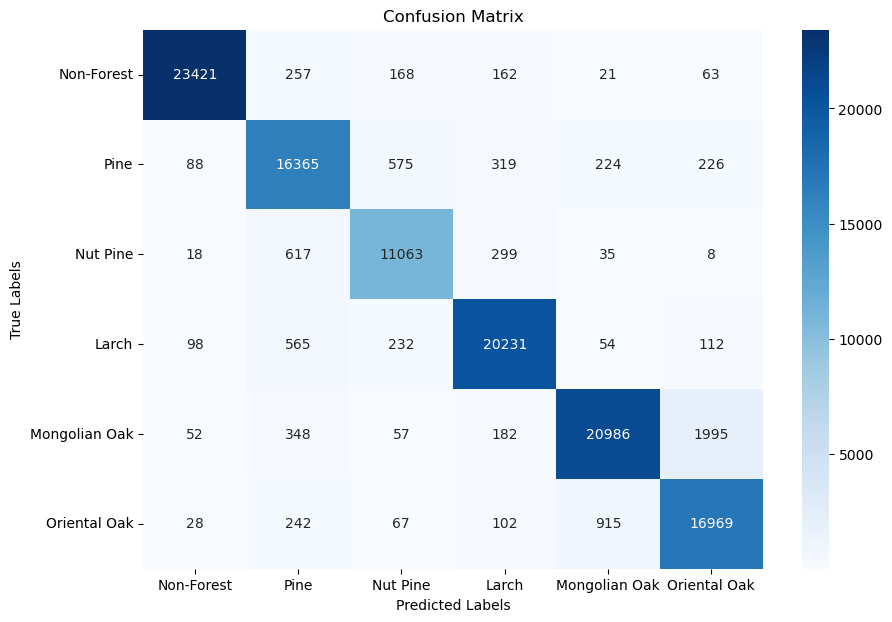

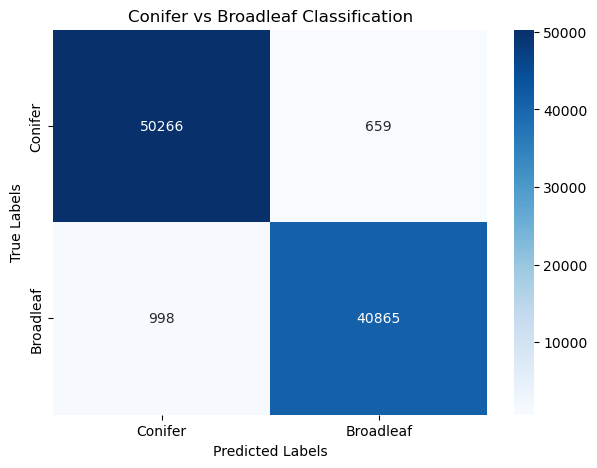

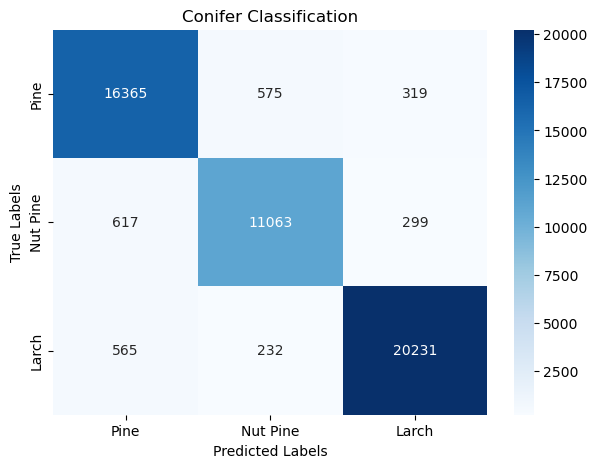

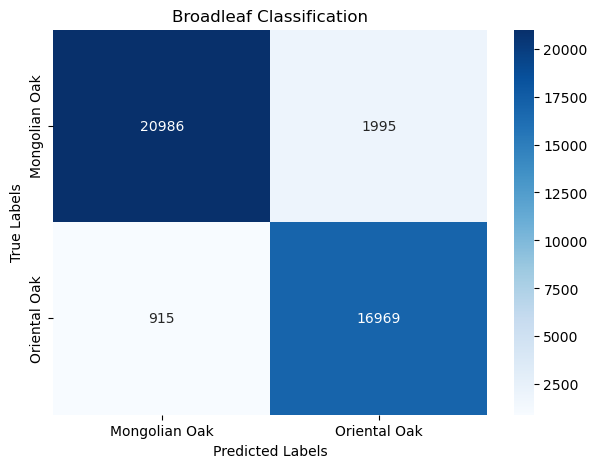

validation data


Evaluation Progress: 100%|██████████| 1159/1159 [00:07<00:00, 158.35it/s]


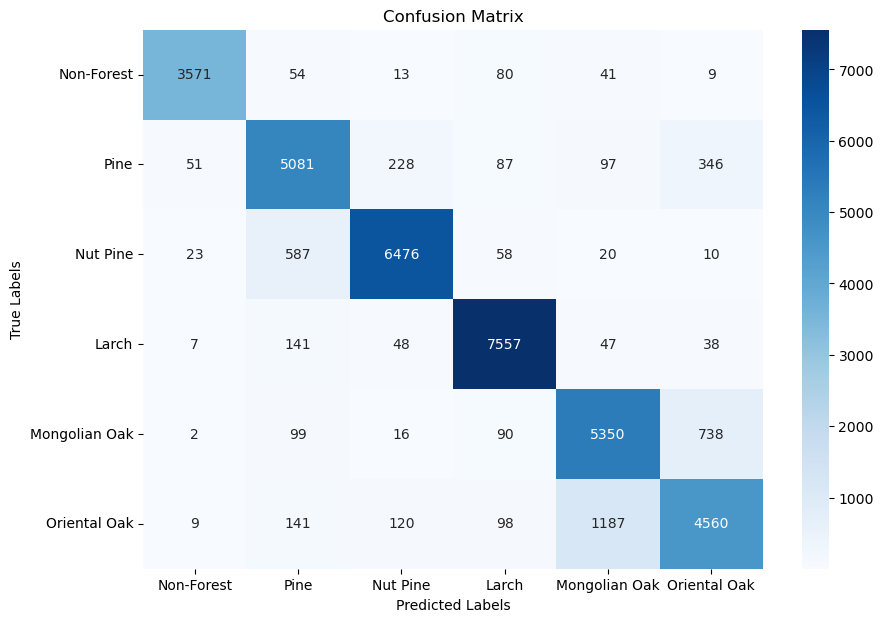

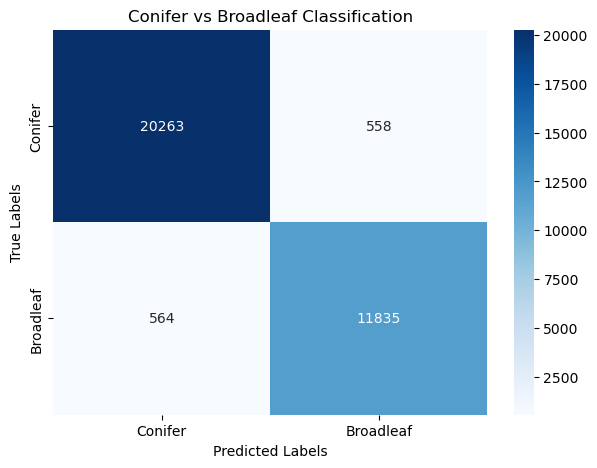

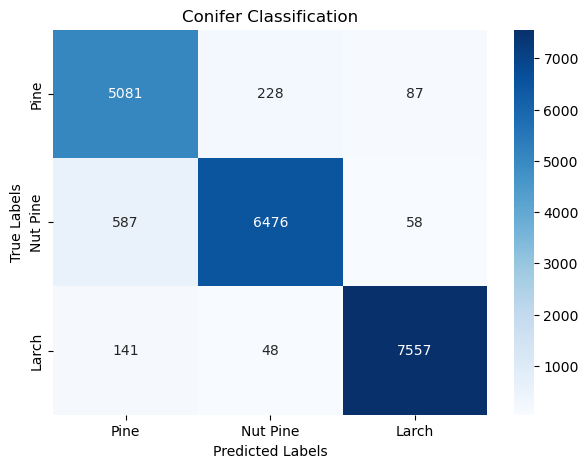

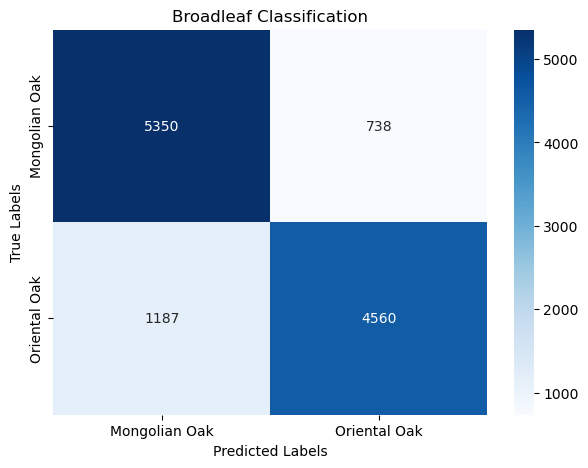

11
Training with patch size: 11


Epoch 1/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 139.66it/s]



Epoch [1/50], Train Loss: 0.4979, Train Accuracy: 81.35%, Val Loss: 0.5232, Val Accuracy: 81.78%



Epoch 2/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 143.35it/s]



Epoch [2/50], Train Loss: 0.3646, Train Accuracy: 86.47%, Val Loss: 0.5769, Val Accuracy: 79.86%



Epoch 3/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 143.49it/s]



Epoch [3/50], Train Loss: 0.3162, Train Accuracy: 88.33%, Val Loss: 0.7188, Val Accuracy: 77.59%



Epoch 4/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.47it/s]



Epoch [4/50], Train Loss: 0.2830, Train Accuracy: 89.60%, Val Loss: 0.5328, Val Accuracy: 83.89%



Epoch 5/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 143.92it/s]



Epoch [5/50], Train Loss: 0.2594, Train Accuracy: 90.41%, Val Loss: 0.5086, Val Accuracy: 84.73%



Epoch 6/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.25it/s]



Epoch [6/50], Train Loss: 0.2434, Train Accuracy: 91.08%, Val Loss: 0.6088, Val Accuracy: 81.51%



Epoch 7/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.32it/s]



Epoch [7/50], Train Loss: 0.2273, Train Accuracy: 91.76%, Val Loss: 0.6717, Val Accuracy: 84.83%



Epoch 8/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 139.90it/s]



Epoch [8/50], Train Loss: 0.2151, Train Accuracy: 92.18%, Val Loss: 0.6258, Val Accuracy: 83.76%



Epoch 9/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.69it/s]



Epoch [9/50], Train Loss: 0.2029, Train Accuracy: 92.58%, Val Loss: 0.5585, Val Accuracy: 85.36%



Epoch 10/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 143.28it/s]



Epoch [10/50], Train Loss: 0.1913, Train Accuracy: 93.04%, Val Loss: 0.5982, Val Accuracy: 86.50%



Epoch 11/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 143.69it/s]



Epoch [11/50], Train Loss: 0.1852, Train Accuracy: 93.21%, Val Loss: 0.5687, Val Accuracy: 85.93%



Epoch 12/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.70it/s]



Epoch [12/50], Train Loss: 0.1748, Train Accuracy: 93.58%, Val Loss: 0.5964, Val Accuracy: 83.93%



Epoch 13/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.74it/s]



Epoch [13/50], Train Loss: 0.1689, Train Accuracy: 93.81%, Val Loss: 0.5770, Val Accuracy: 83.66%



Epoch 14/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.73it/s]



Epoch [14/50], Train Loss: 0.1615, Train Accuracy: 94.15%, Val Loss: 0.5047, Val Accuracy: 86.52%



Epoch 15/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.65it/s]



Epoch [15/50], Train Loss: 0.1554, Train Accuracy: 94.36%, Val Loss: 0.5205, Val Accuracy: 86.55%



Epoch 16/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 143.38it/s]



Epoch [16/50], Train Loss: 0.1491, Train Accuracy: 94.56%, Val Loss: 0.5726, Val Accuracy: 87.09%



Epoch 17/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.79it/s]



Epoch [17/50], Train Loss: 0.1443, Train Accuracy: 94.77%, Val Loss: 0.5917, Val Accuracy: 85.90%



Epoch 18/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.18it/s]



Epoch [18/50], Train Loss: 0.1391, Train Accuracy: 94.94%, Val Loss: 0.5854, Val Accuracy: 85.09%



Epoch 19/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.54it/s]



Epoch [19/50], Train Loss: 0.1337, Train Accuracy: 95.10%, Val Loss: 0.5987, Val Accuracy: 85.99%



Epoch 20/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.74it/s]



Epoch [20/50], Train Loss: 0.1301, Train Accuracy: 95.28%, Val Loss: 0.6585, Val Accuracy: 84.21%



Epoch 21/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 143.15it/s]



Epoch [21/50], Train Loss: 0.1256, Train Accuracy: 95.41%, Val Loss: 0.5170, Val Accuracy: 85.51%



Epoch 22/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.55it/s]



Epoch [22/50], Train Loss: 0.1199, Train Accuracy: 95.70%, Val Loss: 0.5297, Val Accuracy: 87.45%



Epoch 23/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.57it/s]



Epoch [23/50], Train Loss: 0.1176, Train Accuracy: 95.74%, Val Loss: 0.5714, Val Accuracy: 85.04%



Epoch 24/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.57it/s]



Epoch [24/50], Train Loss: 0.1139, Train Accuracy: 95.87%, Val Loss: 0.6204, Val Accuracy: 85.37%



Epoch 25/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 143.41it/s]



Epoch [25/50], Train Loss: 0.1099, Train Accuracy: 96.03%, Val Loss: 0.7373, Val Accuracy: 85.04%



Epoch 26/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 143.74it/s]



Epoch [26/50], Train Loss: 0.1072, Train Accuracy: 96.14%, Val Loss: 0.7287, Val Accuracy: 85.45%



Epoch 27/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.70it/s]



Epoch [27/50], Train Loss: 0.1045, Train Accuracy: 96.18%, Val Loss: 0.6173, Val Accuracy: 86.70%



Epoch 28/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 143.36it/s]



Epoch [28/50], Train Loss: 0.0993, Train Accuracy: 96.42%, Val Loss: 0.7212, Val Accuracy: 84.62%



Epoch 29/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.89it/s]



Epoch [29/50], Train Loss: 0.0986, Train Accuracy: 96.41%, Val Loss: 0.8042, Val Accuracy: 84.21%



Epoch 30/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 143.59it/s]



Epoch [30/50], Train Loss: 0.0948, Train Accuracy: 96.58%, Val Loss: 0.6453, Val Accuracy: 86.53%



Epoch 31/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.66it/s]



Epoch [31/50], Train Loss: 0.0917, Train Accuracy: 96.61%, Val Loss: 0.6791, Val Accuracy: 86.06%



Epoch 32/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 143.35it/s]



Epoch [32/50], Train Loss: 0.0888, Train Accuracy: 96.83%, Val Loss: 0.7642, Val Accuracy: 85.79%



Epoch 33/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.84it/s]



Epoch [33/50], Train Loss: 0.0876, Train Accuracy: 96.78%, Val Loss: 0.8633, Val Accuracy: 84.34%



Epoch 34/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.62it/s]



Epoch [34/50], Train Loss: 0.0818, Train Accuracy: 97.05%, Val Loss: 0.6372, Val Accuracy: 86.10%



Epoch 35/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.52it/s]



Epoch [35/50], Train Loss: 0.0826, Train Accuracy: 96.97%, Val Loss: 0.8550, Val Accuracy: 83.85%



Epoch 36/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.86it/s]



Epoch [36/50], Train Loss: 0.0791, Train Accuracy: 97.18%, Val Loss: 0.5623, Val Accuracy: 86.41%



Epoch 37/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 143.41it/s]



Epoch [37/50], Train Loss: 0.0775, Train Accuracy: 97.16%, Val Loss: 0.6768, Val Accuracy: 87.32%



Epoch 38/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.35it/s]



Epoch [38/50], Train Loss: 0.0751, Train Accuracy: 97.24%, Val Loss: 0.7747, Val Accuracy: 85.61%



Epoch 39/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 143.66it/s]



Epoch [39/50], Train Loss: 0.0732, Train Accuracy: 97.33%, Val Loss: 0.6360, Val Accuracy: 86.99%



Epoch 40/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 143.37it/s]



Epoch [40/50], Train Loss: 0.0713, Train Accuracy: 97.42%, Val Loss: 0.9500, Val Accuracy: 81.29%



Epoch 41/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.54it/s]



Epoch [41/50], Train Loss: 0.0675, Train Accuracy: 97.56%, Val Loss: 0.6404, Val Accuracy: 86.93%



Epoch 42/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 143.28it/s]



Epoch [42/50], Train Loss: 0.0696, Train Accuracy: 97.47%, Val Loss: 0.7700, Val Accuracy: 86.05%



Epoch 43/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.63it/s]



Epoch [43/50], Train Loss: 0.0671, Train Accuracy: 97.57%, Val Loss: 0.7318, Val Accuracy: 85.36%



Epoch 44/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 141.30it/s]



Epoch [44/50], Train Loss: 0.0632, Train Accuracy: 97.69%, Val Loss: 0.7710, Val Accuracy: 86.88%



Epoch 45/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 143.23it/s]



Epoch [45/50], Train Loss: 0.0617, Train Accuracy: 97.78%, Val Loss: 0.7590, Val Accuracy: 85.88%



Epoch 46/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.54it/s]



Epoch [46/50], Train Loss: 0.0621, Train Accuracy: 97.72%, Val Loss: 0.9246, Val Accuracy: 84.63%



Epoch 47/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 143.82it/s]



Epoch [47/50], Train Loss: 0.0585, Train Accuracy: 97.87%, Val Loss: 0.7079, Val Accuracy: 86.52%



Epoch 48/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.88it/s]



Epoch [48/50], Train Loss: 0.0578, Train Accuracy: 97.86%, Val Loss: 0.9171, Val Accuracy: 84.35%



Epoch 49/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 142.41it/s]



Epoch [49/50], Train Loss: 0.0564, Train Accuracy: 97.94%, Val Loss: 0.7860, Val Accuracy: 85.90%



Epoch 50/50 - Validation: 100%|██████████| 1155/1155 [00:08<00:00, 143.62it/s]



Epoch [50/50], Train Loss: 0.0544, Train Accuracy: 98.02%, Val Loss: 0.7863, Val Accuracy: 86.58%

train data


Evaluation Progress: 100%|██████████| 3640/3640 [00:25<00:00, 142.54it/s]


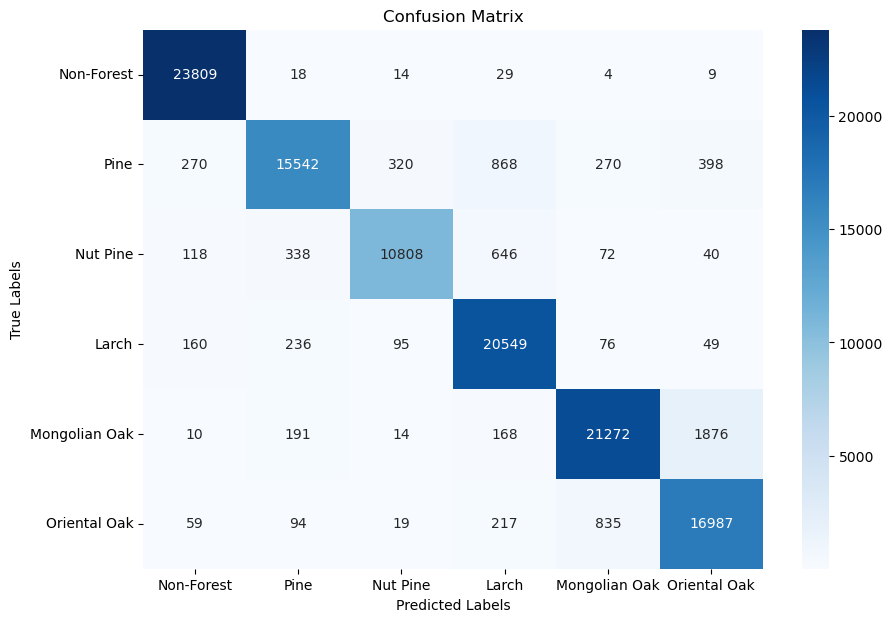

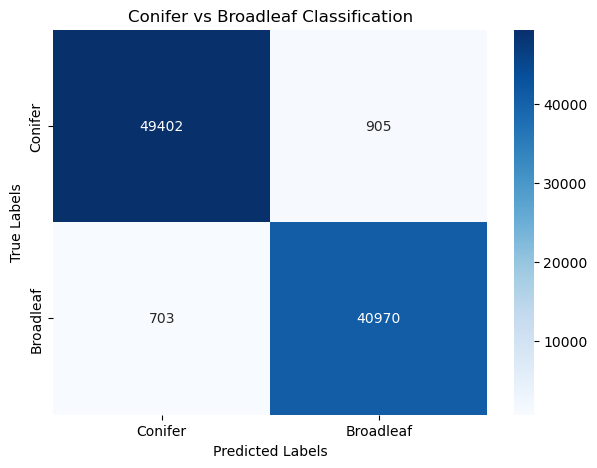

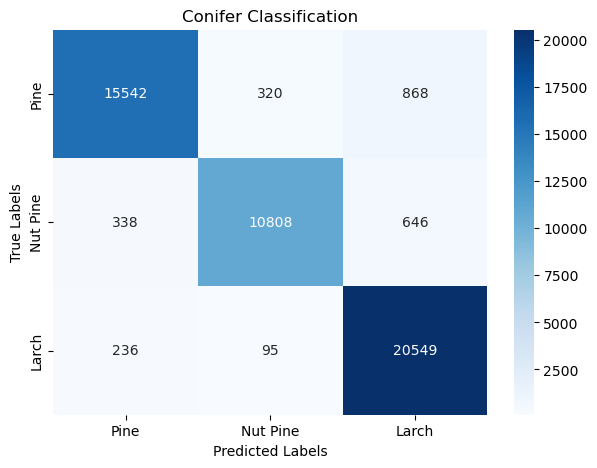

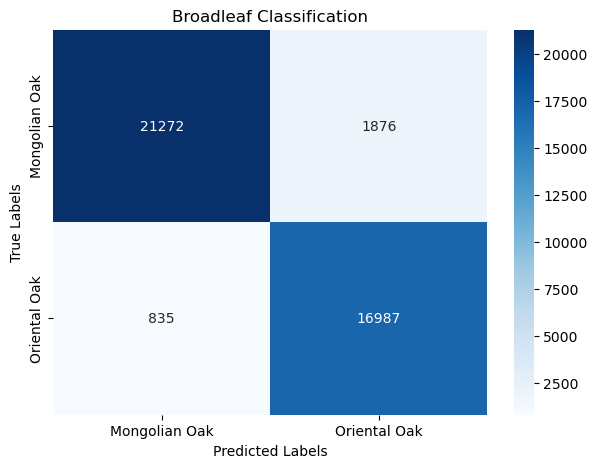

validation data


Evaluation Progress: 100%|██████████| 1155/1155 [00:08<00:00, 141.65it/s]


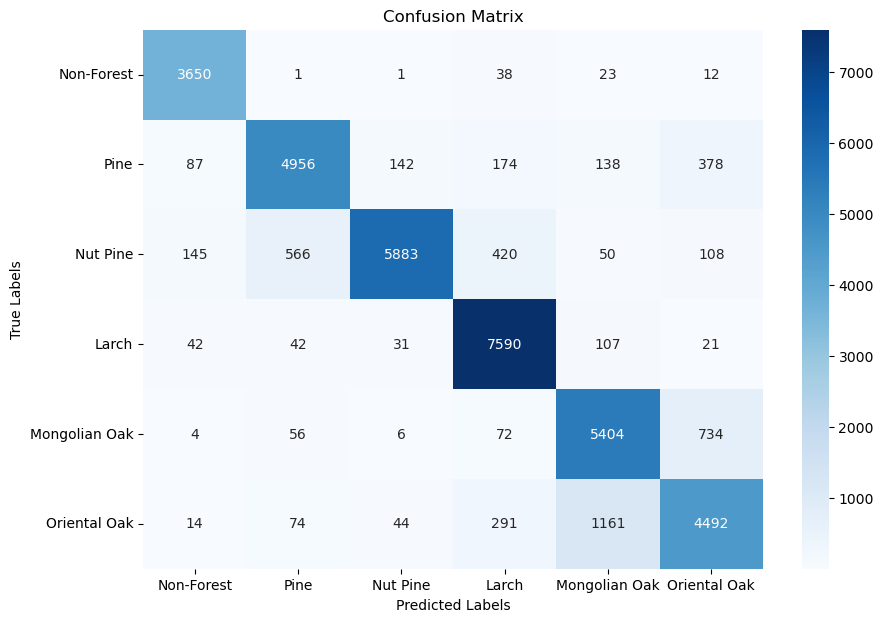

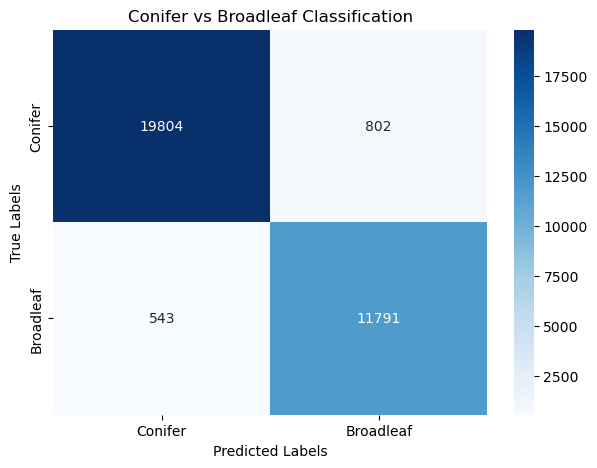

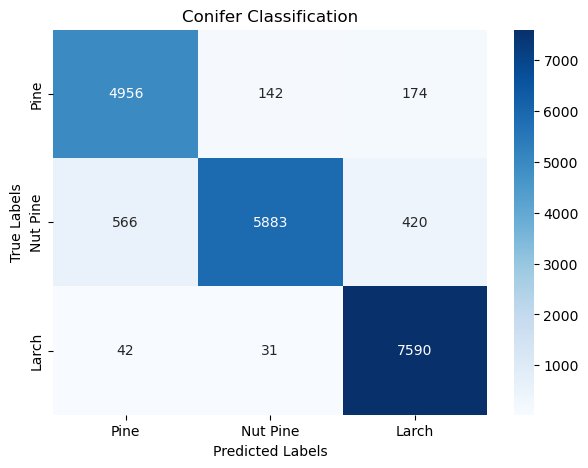

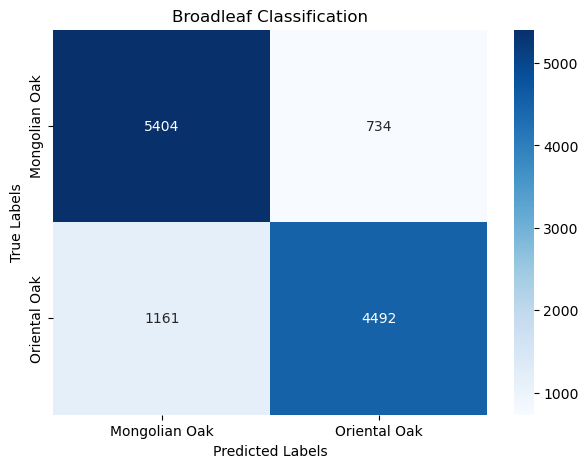

In [5]:
patch_sizes = [1, 3, 5, 7, 9, 11]
result_df_dicts = {"patch_size": [],
                   "data_type" : [],
                   "df" : []}

num_epochs = 50
os.makedirs("./checkpoints/patch_size_test", exist_ok=True) #checkpoints 저장할 dir

for patch_size in patch_sizes:
    print(patch_size)
    train_dataset, val_dataset = create_datasets(patch_size)
    train_loader, val_loader = create_dataloaders(train_dataset, val_dataset)
    
    print(f"Training with patch size: {patch_size}")

    model = ResNetLike_48(num_classes=6).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_model_state, train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100
    )
    
    torch.save(best_model_state, f"./checkpoints/patch_size_test/ResNetLike_48_{patch_size}_{num_epochs}.pth")
    model.load_state_dict(best_model_state)
    
    print("train data")
    train_df = evaluate_model_with_cm(model, train_loader, num_classes=6)
    result_df_dicts["patch_size"].append(patch_size)
    result_df_dicts["data_type"].append("train_data")
    result_df_dicts["df"].append(train_df)
    
    print("validation data")
    validation_df = evaluate_model_with_cm(model, val_loader, num_classes=6)
    result_df_dicts["patch_size"].append(patch_size)
    result_df_dicts["data_type"].append("validation")
    result_df_dicts["df"].append(validation_df)

In [6]:
# 모든 데이터를 하나의 데이터프레임으로 합치기
final_df = pd.concat([
    df.assign(patch_size=patch, data_type=dt)
    for patch, dt, df in zip(result_df_dicts["patch_size"], result_df_dicts["data_type"], result_df_dicts["df"])
], ignore_index=False)

# 인덱스를 리셋하고 정리
final_df.reset_index(inplace=True)
final_df.rename(columns={"index": "class"}, inplace=True)

# 저장
os.makedirs("./results", exist_ok=True) 
final_df.to_csv("./results/patch_size_results.csv", index=False, encoding="utf-8-sig")